In [1]:
# 加载数据于格式转化
import warnings
warnings.filterwarnings('ignore')#忽略提醒
import pandas as pd  

In [2]:
import numpy as np

In [39]:
# 加载原始数据  
df = pd.read_csv('UserBehaviorG.csv', names=['user_id','item_id','category_id','behavior','timestamp'])  

In [3]:
import gc
gc.collect()  # 强制垃圾回收

0

In [40]:
# 检查数据类型分布
print(df.dtypes)

user_id         int64
item_id         int64
category_id     int64
behavior       object
timestamp       int64
dtype: object


In [6]:
from sklearn.preprocessing import LabelEncoder

# Step 1: 标签编码分类字段
le = LabelEncoder()
df['behavior_encoded'] = le.fit_transform(df['behavior'])  # 'pv'→0, 'fav'→1, 'cart'→2, 'buy'→3

# Step 2: 选择数值字段并转换类型
numeric_cols = ['user_id', 'item_id', 'category_id', 'behavior_encoded', 'timestamp']
df_optimized = df[numeric_cols].astype(np.float32)

# Step 3: 内存优化验证
original_memory = df.memory_usage(deep=True).sum()  # 原始内存占用
optimized_memory = df_optimized.memory_usage(deep=True).sum()
print(f"内存节省比例: {(original_memory - optimized_memory)/original_memory:.1%}")

内存节省比例: 79.0%


In [41]:
df.head()

,user_id,item_id,category_id,behavior,timestamp
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885
3,1,3830808,4181361,pv,1511593493
4,1,4365585,2520377,pv,1511596146


In [8]:
# Step 3: 验证编码结果
print("编码后行为映射：")
print(le.classes_)
print(df[['behavior', 'behavior_encoded']].head())

编码后行为映射：
['buy' 'cart' 'fav' 'pv']
  behavior  behavior_encoded
0       pv                 3
1       pv                 3
2       pv                 3
3       pv                 3
4       pv                 3


In [9]:
# 时间戳转为datetime格式  
df['time'] = pd.to_datetime(df['timestamp'], unit='s')  
df = df.sort_values(by=['user_id', 'time'])  

In [10]:
df.head() #读取前五条信息

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time
0,1,2268318,2520377,pv,1511544070,3,2017-11-24 17:21:10
1,1,2333346,2520771,pv,1511561733,3,2017-11-24 22:15:33
2,1,2576651,149192,pv,1511572885,3,2017-11-25 01:21:25
3,1,3830808,4181361,pv,1511593493,3,2017-11-25 07:04:53
4,1,4365585,2520377,pv,1511596146,3,2017-11-25 07:49:06


In [11]:
# ========================
# 初始化清洗统计记录表
# ========================
cleaning_stats = []
def record_step(step_name, before, after):
    """记录每个清洗步骤的数据量变化"""
    if before == 0:
        pct_filtered = 0.0
    else:
        pct_filtered = round((before - after) / before * 100, 2)  # 使用 Python 内置 round 函数
    cleaning_stats.append({
        "步骤名称": step_name,
        "原始数据量": before,
        "处理后数据量": after,
        "过滤比例(%)": pct_filtered
    })

In [12]:
# ========================
# 记录初始数据量
# ========================
original_count = len(df)
record_step("初始数据", original_count, original_count)
print(cleaning_stats)

[{'步骤名称': '初始数据', '原始数据量': 100150807, '处理后数据量': 100150807, '过滤比例(%)': 0.0}]


In [13]:
# 精确计算时间差（使用shift）
df['prev_time'] = df.groupby(['user_id', 'item_id'])['time'].shift()
df['time_diff'] = (df['time'] - df['prev_time']).dt.total_seconds().fillna(1)

In [14]:
# 过滤逻辑（正确使用运算符优先级）
df_clean = df[
    (df['prev_time'].isna()) |  # 保留首次点击
    ((df['prev_time'].notna()) & (df['time_diff'] > 1))  # 排除非首次点击的1秒内记录
]

# 4. 验证保存结果
print(f"清洗后数据量: {len(df_clean)}")
df_clean.head()

清洗后数据量: 100140501


,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff
0,1,2268318,2520377,pv,1511544070,3,2017-11-24 17:21:10,NaT,1.0
1,1,2333346,2520771,pv,1511561733,3,2017-11-24 22:15:33,NaT,1.0
2,1,2576651,149192,pv,1511572885,3,2017-11-25 01:21:25,NaT,1.0
3,1,3830808,4181361,pv,1511593493,3,2017-11-25 07:04:53,NaT,1.0
4,1,4365585,2520377,pv,1511596146,3,2017-11-25 07:49:06,NaT,1.0


In [15]:
# ========================
# 记录瞬时重复点击处理
# ========================
df = df_clean
current_count = len(df)  # 实际清洗后的数据量
print(original_count, current_count)
record_step("瞬时点击重复处理", original_count, current_count)

100150807 100140501


In [16]:
df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff
0,1,2268318,2520377,pv,1511544070,3,2017-11-24 17:21:10,NaT,1.0
1,1,2333346,2520771,pv,1511561733,3,2017-11-24 22:15:33,NaT,1.0
2,1,2576651,149192,pv,1511572885,3,2017-11-25 01:21:25,NaT,1.0
3,1,3830808,4181361,pv,1511593493,3,2017-11-25 07:04:53,NaT,1.0
4,1,4365585,2520377,pv,1511596146,3,2017-11-25 07:49:06,NaT,1.0


In [17]:
def analyze_repeat_users_safely(df):
    """高频用户分析（带容错机制）"""
    # 数据有效性过滤
    valid_df = df[
        (df['time_diff'].notna()) & 
        (df['time_diff'] >= 0) &
        (df['prev_time'].notna())
    ]
    
    # 统计高频用户
    if valid_df.empty:
        print("⚠️ 无有效数据可供分析")
        return pd.Series(dtype='int64')
    
    repeat_users = valid_df[
        valid_df['time_diff'] < 1
    ]['user_id'].value_counts().head(10)
    
    # 验证结果
    assert not repeat_users.empty, "高频用户统计结果为空"
    
    return repeat_users

# 执行分析
result = analyze_repeat_users_safely(df)
print("安全统计结果：", result)

AssertionError: 高频用户统计结果为空

In [18]:
gc.collect()  # 强制垃圾回收

0

In [19]:
def filter_high_frequency_users(df, threshold=1000, debug=False):
    """过滤单日行为超过阈值的用户（仅过滤超频日期的记录）"""
    
    # 确保时间戳正确转换
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df['date'] = df['time'].dt.date
    
    # 确保user_id为整数类型
    df['user_id'] = df['user_id'].astype(int)
    
    # 按用户+日期统计行为量
    daily_counts = df.groupby(['user_id', 'date']).size().reset_index(name='count')
    
    # 调试输出优化（仅显示前10条）
    if debug:
        print("超频日期统计（TOP10）：")
        print(daily_counts[daily_counts['count'] > threshold].head(10))
    
    # 创建布尔掩码
    mask = df.set_index(['user_id', 'date']).index.isin(
        high_freq_dates := daily_counts[daily_counts['count'] > threshold].set_index(['user_id', 'date']).index
    )
    
    # 执行过滤
    filtered_df = df.loc[~mask].copy()
    
    return filtered_df

In [20]:
# 
test_df = pd.DataFrame({
    'user_id': [1]*1100 + [2]*200,  # 手动控制数量
    'time': pd.date_range(start='2023-01-01 00:00:00', periods=1300, freq='T')[:2000]  # 确保时间戳连续
})

filtered = filter_high_frequency_users(test_df, threshold=1000)
assert len(filtered) == 200, f"Expected 500, got {len(filtered)}"

In [21]:
# 执行过滤（阈值=1000）
before = len(df)
df = filter_high_frequency_users(df, threshold=1000)
after = len(df)

# 更新清洗统计
record_step("超高频行为过滤", before, after)
print(cleaning_stats)

[{'步骤名称': '初始数据', '原始数据量': 100150807, '处理后数据量': 100150807, '过滤比例(%)': 0.0}, {'步骤名称': '瞬时点击重复处理', '原始数据量': 100150807, '处理后数据量': 100140501, '过滤比例(%)': 0.01}, {'步骤名称': '超高频行为过滤', '原始数据量': 100140501, '处理后数据量': 100140501, '过滤比例(%)': 0.0}]


In [22]:
gc.collect()  # 强制垃圾回收

18

In [23]:
def split_and_filter_sessions(df, min_session_duration=1800, min_actions=3):
    """会话划分与过滤"""
    
    # 1. 数据预处理
    df = df.sort_values(by=['user_id', 'time'])  # 按用户和时间排序
    df = df.reset_index(drop=True)  # 重置索引确保顺序连续
    
    # 2. 计算相邻行为时间差
    df['prev_time'] = df.groupby('user_id')['time'].shift(1)
    df['session_gap'] = (df['time'] - df['prev_time']).dt.total_seconds().fillna(0)

    # 3. 生成会话ID
    df['session_id'] = (df['session_gap'] > min_session_duration).cumsum() + 1  # 从1开始编号
    
    # 4. 过滤短会话
    session_stats = df.groupby(['user_id', 'session_id']).size().reset_index(name='action_count')
    valid_sessions = session_stats[session_stats['action_count'] >= min_actions]
    
    # 5. 合并有效会话
    df = df.merge(valid_sessions, on=['user_id', 'session_id'], how='inner')
    
    return df

In [24]:
# 生成测试数据（user_id=1在30分钟内连续点击5次）
test_df = pd.DataFrame({
    'user_id': [1]*5,
    'time': pd.date_range(start='2023-01-01 00:00:00', periods=5, freq='T'),
    'behavior': ['pv']*5
})

# 执行会话划分（默认阈值1800秒，最少3次行为）
filtered_df = split_and_filter_sessions(test_df)

# 验证结果
assert len(filtered_df) == 5, f"Expected 5 records, got {len(filtered_df)}"
print("✅ 测试通过：基础会话划分正确")

✅ 测试通过：基础会话划分正确


In [25]:
#  执行会话划分（默认阈值1800秒，最少3次行为）
df = split_and_filter_sessions(df)

In [26]:
gc.collect()  # 强制垃圾回收
df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count
0,1,266784,2520771,pv,1511909676,3,2017-11-28 22:54:36,2017-11-28 18:12:52,25123.0,2017-11-28,16904.0,23,3
1,1,4092065,2355072,pv,1511910242,3,2017-11-28 23:04:02,2017-11-28 22:54:36,1.0,2017-11-28,566.0,23,3
2,1,1305059,2520771,pv,1511911930,3,2017-11-28 23:32:10,2017-11-28 23:04:02,1.0,2017-11-28,1688.0,23,3
3,2,111223,4130426,fav,1511700967,2,2017-11-26 12:56:07,2017-11-26 04:22:12,1.0,2017-11-26,30835.0,50,8
4,2,4982883,4130426,pv,1511700994,3,2017-11-26 12:56:34,2017-11-26 12:56:07,1.0,2017-11-26,27.0,50,8


In [27]:
# ========================
# 记录无效会话过滤
# ========================
current_count = len(df)  # 实际清洗后的数据量
print(original_count, current_count)
record_step("无效会话过滤", original_count, current_count)

100150807 90236191


In [28]:
def remove_zombie_users(df, min_pv_count=1):
    """精准剔除仅单次PV行为的僵尸用户"""
    
    # 1. 数据预处理（严格排序）
    df = df.sort_values(by=['user_id', 'timestamp'])
    df = df.reset_index(drop=True)
    
    # 2. 计算每个用户的首次行为类型及总PV次数
    first_behavior = df.groupby('user_id')['behavior'].first()
    pv_counts = df.groupby('user_id')['behavior'].apply(lambda x: (x == 'pv').sum())
    
    # 3. 定义僵尸用户条件（仅单次PV且首次行为为PV）
    zombie_mask = (
        (first_behavior == 'pv') &  # 首次行为为PV
        (pv_counts == min_pv_count)  # 总PV次数等于阈值
    )
    
    # 4. 筛选僵尸用户并过滤
    zombies = df[df['user_id'].isin(zombie_mask[zombie_mask].index)]
    df_clean = df[~df['user_id'].isin(zombies['user_id'])].copy()
    
    return df_clean

In [29]:
# 生成混合行为数据（user_id=1有2次PV和1次FAV）
test_df = pd.DataFrame({
    'user_id': [1]*3,
    'timestamp': pd.date_range(start='2023-01-01', periods=3, freq='H'),
    'behavior': ['pv', 'fav', 'pv']
})

df_clean = remove_zombie_users(test_df, min_pv_count=2)
assert len(df_clean) == 0, "应过滤混合行为用户"

In [30]:
# 剔除僵尸用户（仅1次pv）  
df = remove_zombie_users(df)

In [31]:
gc.collect()  # 强制垃圾回收
df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count
0,1,266784,2520771,pv,1511909676,3,2017-11-28 22:54:36,2017-11-28 18:12:52,25123.0,2017-11-28,16904.0,23,3
1,1,4092065,2355072,pv,1511910242,3,2017-11-28 23:04:02,2017-11-28 22:54:36,1.0,2017-11-28,566.0,23,3
2,1,1305059,2520771,pv,1511911930,3,2017-11-28 23:32:10,2017-11-28 23:04:02,1.0,2017-11-28,1688.0,23,3
3,2,111223,4130426,fav,1511700967,2,2017-11-26 12:56:07,2017-11-26 04:22:12,1.0,2017-11-26,30835.0,50,8
4,2,4982883,4130426,pv,1511700994,3,2017-11-26 12:56:34,2017-11-26 12:56:07,1.0,2017-11-26,27.0,50,8


In [32]:
# ========================
# 记录僵尸用户剔除
# ========================
current_count = len(df)  # 实际清洗后的数据量
print(original_count, current_count)
record_step("僵尸用户剔除", original_count, current_count)

100150807 90235084


In [33]:
# ========================
# 生成统计表格
# ========================
stats_df = pd.DataFrame(cleaning_stats)
stats_df["过滤比例(%)"] = stats_df["过滤比例(%)"].astype(str) + "%"

print("\n数据清洗效果统计:")
print(stats_df.to_csv(sep='\t', na_rep='nan'))


数据清洗效果统计:
	步骤名称	原始数据量	处理后数据量	过滤比例(%)
0	初始数据	100150807	100150807	0.0%
1	瞬时点击重复处理	100150807	100140501	0.01%
2	超高频行为过滤	100140501	100140501	0.0%
3	无效会话过滤	100150807	90236191	9.9%
4	僵尸用户剔除	100150807	90235084	9.9%



In [36]:
def mark_longtail_users(df, max_actions=1):
    """
    标记总行为次数≤max_actions的长尾用户
    
    参数：
        df: 原始数据 (需包含 'user_id', 'behavior', 'timestamp' 字段)
        max_actions: 长尾用户阈值，默认1次
    
    返回：
        df_marked: 包含长尾用户标记的DataFrame
        longtail_users: 长尾用户ID列表
    """
    # 正确解析日期字符串（移除unit='s'参数）
    df['timestamp'] = pd.to_datetime(df['timestamp'])  # 自动识别日期格式
    
    # 按用户ID统计总行为次数
    user_activity = df.groupby('user_id', observed=False)['behavior'].count().reset_index()
    user_activity.columns = ['user_id', 'total_actions']
    
    # 定义长尾用户（总行为次数≤阈值）
    longtail_mask = user_activity['total_actions'] <= max_actions
    longtail_users = user_activity[longtail_mask]['user_id'].tolist()
    
    # 在原始数据中添加标记列
    df_marked = df.copy()
    df_marked['is_longtail'] = df_marked['user_id'].isin(longtail_users)
    
    return df_marked, longtail_users

In [38]:
# 生成测试数据（用户1有2次行为，用户2有1次）
test_df = pd.DataFrame({
    'user_id': [1, 1, 2],
    'timestamp': [
        '2023-11-01 08:00:00', '2023-11-05 12:00:00', 
        '2023-11-10 15:00:00'
    ],
    'behavior': ['pv', 'fav', 'pv']
})

# 修正时间解析逻辑
df_marked, longtail_users = mark_longtail_users(test_df)  # 自动解析日期字符串

# 验证结果
assert len(df_marked[df_marked['is_longtail']]) == 1  # 用户2被标记
assert longtail_users == [2]

In [34]:
print(f"加载数据量: {len(df)} 行")

加载数据量: 90235084 行


In [35]:
df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count
0,1,266784,2520771,pv,1511909676,3,2017-11-28 22:54:36,2017-11-28 18:12:52,25123.0,2017-11-28,16904.0,23,3
1,1,4092065,2355072,pv,1511910242,3,2017-11-28 23:04:02,2017-11-28 22:54:36,1.0,2017-11-28,566.0,23,3
2,1,1305059,2520771,pv,1511911930,3,2017-11-28 23:32:10,2017-11-28 23:04:02,1.0,2017-11-28,1688.0,23,3
3,2,111223,4130426,fav,1511700967,2,2017-11-26 12:56:07,2017-11-26 04:22:12,1.0,2017-11-26,30835.0,50,8
4,2,4982883,4130426,pv,1511700994,3,2017-11-26 12:56:34,2017-11-26 12:56:07,1.0,2017-11-26,27.0,50,8


In [4]:
import os
from datetime import datetime

# ------------------------- 保存清洗结果 -------------------------
def save_cleaned_data(cleaned_df, save_dir="./cleaned_data/", format="parquet"):
    """
    保存清洗后的数据及元数据
    :param cleaned_df: 清洗完成的DataFrame
    :param save_dir: 保存目录路径
    :param format: 保存格式 (parquet/csv/pickle)
    """
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    
    # 生成带时间戳的文件名
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    filename = f"taobao_cleaned_{timestamp}"
    
    # 保存数据文件
    if format == "parquet":
        cleaned_df.to_parquet(f"{save_dir}{filename}.parquet")
    elif format == "csv":
        cleaned_df.to_csv(f"{save_dir}{filename}.csv.gz", index=False, compression="gzip")
    elif format == "pickle":
        cleaned_df.to_pickle(f"{save_dir}{filename}.pkl")
    else:
        raise ValueError("不支持该格式，请选择 parquet/csv/pickle")

    # 保存元数据（处理步骤记录）
    metadata = {
        "清洗时间": timestamp,
        "最终数据量": len(cleaned_df),
        "保存格式": format,
        "字段列表": list(cleaned_df.columns)
    }
    pd.DataFrame([metadata]).to_csv(f"{save_dir}metadata_log.csv", mode='a', header=not os.path.exists(f"{save_dir}metadata_log.csv"))
    
    print(f"数据已保存至: {save_dir}{filename}.{format}")

# ------------------------- 读取清洗结果 -------------------------
def load_cleaned_data(file_path):
    """
    读取清洗后的数据文件
    :param file_path: 文件路径（如 ./cleaned_data/taobao_cleaned_20231001.parquet）
    :return: 加载的DataFrame
    """
    if file_path.endswith(".parquet"):
        return pd.read_parquet(file_path)
    elif file_path.endswith(".csv.gz"):
        return pd.read_csv(file_path, compression="gzip")
    elif file_path.endswith(".pkl"):
        return pd.read_pickle(file_path)
    else:
        raise ValueError("不支持的文件格式")


In [ ]:
df.head()

In [19]:
longtail_users.head()

,user_id,item_id,category_id,behavior,timestamp,time,time_diff,date,user_shift,session_gap,session_id
3,2,111223,4130426,fav,1511700967,2017-11-26 12:56:07,1.0,2017-11-26,2017-11-26 04:22:12,30835.0,49
4,2,4982883,4130426,pv,1511700994,2017-11-26 12:56:34,1.0,2017-11-26,2017-11-26 12:56:07,27.0,49
5,2,4768250,4130426,pv,1511701129,2017-11-26 12:58:49,1.0,2017-11-26,2017-11-26 12:56:34,135.0,49
6,2,4870037,1277467,fav,1511701183,2017-11-26 12:59:43,1.0,2017-11-26,2017-11-26 12:58:49,54.0,49
7,2,4768250,4130426,fav,1511701205,2017-11-26 13:00:05,76.0,2017-11-26,2017-11-26 12:59:43,22.0,49


In [37]:
 # 保存清洗过后的数据
save_cleaned_data(df, format="csv")

数据已保存至: ./cleaned_data/taobao_cleaned_20250329_1920.csv


In [28]:
import pandas as pd
import numpy as np

def downsample_users_safe(data, ratio=0.5, seed=42):
    """安全增强版分层抽样（修复列名丢失与种子错误）"""
    
    # 参数校验
    if not isinstance(ratio, (float, int)) or not (0 <= ratio <= 1):
        raise ValueError("ratio必须为0-1之间的数值")
    if not isinstance(seed, int) or seed < 0:
        raise ValueError("seed必须为非负整数")
    
    # 计算用户活跃度
    user_activity = data.groupby('user_id', observed=False)['behavior'].count().reset_index()
    user_activity.columns = ['user_id', 'activity']
    
    # 分层抽样逻辑
    threshold = user_activity['activity'].median()
    user_activity['strata'] = np.where(
        user_activity['activity'] >= threshold, 
        'high', 
        'low'
    )
    
    # 修复抽样逻辑
    sampled_users = []
    for stratum in ['high', 'low']:
        stratum_users = user_activity[user_activity['strata'] == stratum]
        if stratum_users.empty:
            continue  # 跳过空分层
        
        sample_size = max(1, min(int(len(stratum_users) * ratio), len(stratum_users)))
        
        # 安全生成随机种子
        safe_seed = (seed + hash(stratum)) % (2**32)
        rng = np.random.default_rng(safe_seed)
        
        sampled = stratum_users.sample(
            n=sample_size, 
            random_state=rng
        ).reset_index(drop=True)  # 重置索引避免冲突
        
        sampled_users.append(sampled[['user_id']])  # 显式保留user_id列
    
    # 合并并去重
    if not sampled_users:
        raise ValueError("所有分层均无有效用户")
    
    sampled_df = pd.concat(sampled_users, ignore_index=True)
    unique_users = sampled_df['user_id'].unique()
    
    # 过滤原数据
    downsampled = data[data['user_id'].isin(unique_users)].copy()
    return downsampled

In [29]:
test_df = pd.DataFrame({
    'user_id': [1]*10 + [2]*5 + [3]*3,
    'behavior': ['pv']*18
})

downsampled = downsample_users_safe(test_df, ratio=0.5, seed=42)

# 验证抽样结果
assert 'user_id' in downsampled.columns, "列名丢失"
assert len(downsampled) <= len(test_df), "抽样比例异常"
print("✅ 测试通过：列名保留且抽样比例正常")

# 验证用户ID类型一致性
assert downsampled['user_id'].dtype == test_df['user_id'].dtype, "数据类型不匹配"

✅ 测试通过：列名保留且抽样比例正常


In [43]:
df = downsample_users(df, ratio=0.5, seed=42)

In [44]:
print(len(df))

45123245


In [45]:
df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count
0,1,266784,2520771,pv,1511909676,3,2017-11-28 22:54:36,2017-11-28 18:12:52,25123.0,2017-11-28,16904.0,23,3
1,1,4092065,2355072,pv,1511910242,3,2017-11-28 23:04:02,2017-11-28 22:54:36,1.0,2017-11-28,566.0,23,3
2,1,1305059,2520771,pv,1511911930,3,2017-11-28 23:32:10,2017-11-28 23:04:02,1.0,2017-11-28,1688.0,23,3
3,2,111223,4130426,fav,1511700967,2,2017-11-26 12:56:07,2017-11-26 04:22:12,1.0,2017-11-26,30835.0,50,8
4,2,4982883,4130426,pv,1511700994,3,2017-11-26 12:56:34,2017-11-26 12:56:07,1.0,2017-11-26,27.0,50,8


In [3]:
def validate_sampling(cleaned_df, small_df):
    """完整抽样验证流程"""
    # 检查列存在性
    required_cols = ['user_id', 'behavior']
    for col in required_cols:
        assert col in cleaned_df.columns, f"{col}列在原始数据中缺失"
        assert col in small_df.columns, f"{col}列在抽样数据中缺失"
    
    # 计算用户缩减率
    original_users = cleaned_df['user_id'].nunique()
    sampled_users = small_df['user_id'].nunique()
    print(f"用户缩减率: {1 - sampled_users/original_users:.1%}")
    
    # 检查行为分布相似度
    orig_dist = cleaned_df['behavior'].value_counts(normalize=True)
    samp_dist = small_df['behavior'].value_counts(normalize=True)
    
    # 确保所有行为类型一致
    assert set(orig_dist.index) == set(samp_dist.index), "行为类型不一致"
    
    print("行为分布对比:")
    print(pd.DataFrame({'原始数据': orig_dist, '抽样数据': samp_dist}))


In [7]:
# 读洗文件示例
latest_file = "./cleaned_data/taobao_cleaned_20250329_1920.csv.gz"  # 替换为实际路径
cleaned_df = load_cleaned_data(latest_file)

In [21]:
cleaned_df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count
0,1,266784,2520771,pv,1511909676,3,2017-11-28 22:54:36,2017-11-28 18:12:52,25123.0,2017-11-28,16904.0,23,3
1,1,4092065,2355072,pv,1511910242,3,2017-11-28 23:04:02,2017-11-28 22:54:36,1.0,2017-11-28,566.0,23,3
2,1,1305059,2520771,pv,1511911930,3,2017-11-28 23:32:10,2017-11-28 23:04:02,1.0,2017-11-28,1688.0,23,3
3,2,111223,4130426,fav,1511700967,2,2017-11-26 12:56:07,2017-11-26 04:22:12,1.0,2017-11-26,30835.0,50,8
4,2,4982883,4130426,pv,1511700994,3,2017-11-26 12:56:34,2017-11-26 12:56:07,1.0,2017-11-26,27.0,50,8


In [34]:
import gc
gc.collect()  # 强制垃圾回收

0

In [31]:
df = downsample_users_safe(cleaned_df, ratio=0.5, seed=42)

In [32]:
 # 保存清洗过后的数据和筛选过的用户
save_cleaned_data(df, format="csv")

数据已保存至: ./cleaned_data/taobao_cleaned_20250329_2123.csv


In [35]:
# 执行验证
validate_sampling(cleaned_df, df)

用户缩减率: 50.0%
行为分布对比:
              原始数据      抽样数据
behavior                    
pv        0.900083  0.900112
cart      0.054210  0.054174
fav       0.028731  0.028761
buy       0.016977  0.016953


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import defaultdict

In [4]:
# 读取清洗过后的数据和筛选过的用户
latest_file = "./cleaned_data/taobao_cleaned_20250329_2123.csv.gz"  # 替换为实际路径
cleaned_df = load_cleaned_data(latest_file)
print(f"加载数据量: {len(cleaned_df)} 行")

加载数据量: 45115814 行


In [6]:
df = cleaned_df
# 节省内存操作
# 检查数据类型分布# Step 1: 
print(df.dtypes)

user_id               int64
item_id               int64
category_id           int64
behavior             object
timestamp             int64
behavior_encoded      int64
time                 object
prev_time            object
time_diff           float64
date                 object
session_gap         float64
session_id            int64
action_count          int64
dtype: object


In [18]:
from sklearn.preprocessing import LabelEncoder

# Step 2: 选择数值字段并转换类型
numeric_cols = ['time_diff', 'session_gap']
original_memory = df.memory_usage(deep=True).sum()  # 原始内存占用
df[numeric_cols] = df[numeric_cols].astype(np.float32)

# Step 3: 内存优化验证
optimized_memory = df.memory_usage(deep=True).sum()
print(f"内存节省比例: {(original_memory - optimized_memory)/original_memory:.1%}")

内存节省比例: 2.3%


In [19]:
print(df.dtypes)

user_id               int64
item_id               int64
category_id           int64
behavior             object
timestamp             int64
behavior_encoded      int64
time                 object
prev_time            object
time_diff           float32
date                 object
session_gap         float32
session_id            int64
action_count          int64
dtype: object


In [20]:
print(len(df))

45115814


In [20]:
gc.collect()  # 强制垃圾回收

0

In [69]:
# 2017年11月25日至2017年12月3日（共9天）
# 只保留这几天的数据，因为数据之中有其他数据但是很少
import pandas as pd

def filter_date_range(df, start_date='2017-11-25', end_date='2017-12-03'):
    """
    精准过滤指定日期范围的数据（处理时间戳解析错误）
    
    参数：
    df: 原始数据DataFrame
    start_date: 开始日期（格式：YYYY-MM-DD）
    end_date: 结束日期（格式：YYYY-MM-DD）
    
    返回：
    过滤后的DataFrame（仅包含指定日期范围的数据）
    """
    # ======================
    # 关键修复1：正确解析时间戳（单位：秒）
    # ======================
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
    
    # ======================
    # 关键修复2：处理时区问题（转换为UTC+8）
    # ======================
    df['datetime'] = df['datetime'].dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai')
    
    # ======================
    # 关键修复3：精确日期范围过滤
    # ======================
    mask = (df['datetime'] >= start_date) & (df['datetime'] <= end_date)
    filtered_df = df[mask].copy()
    
    # ======================
    # 清理临时列
    # ======================
    filtered_df.drop(columns=['datetime'], inplace=True)
    
    return filtered_df

In [11]:
filtered_df = filter_date_range(df, '2017-11-25', '2017-12-03')

In [13]:
print(len(df))

45115814


In [14]:
print(len(filtered_df))

38931391


In [17]:
 # 保存清洗过后的数据和筛选过,且筛选出正确时间的用户
save_cleaned_data(filtered_df, format="csv")

数据已保存至: ./cleaned_data/taobao_cleaned_20250330_1845.csv


In [7]:
# 读取清洗过后的数据和筛选过的用户
latest_file = "./cleaned_data/taobao_cleaned_20250329_2123.csv.gz"  # 替换为实际路径
cleaned_df = load_cleaned_data(latest_file)
print(f"加载数据量: {len(cleaned_df)} 行")

FileNotFoundError: [Errno 2] No such file or directory: './cleaned_data/taobao_cleaned_20250329_2123.csv.gz'

In [6]:
df = cleaned_df
df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count
0,3,2775969,2355072,fav,1511700774,2,2017-11-26 12:52:54,2017-11-25 10:24:02,1.0,2017-11-26,95332.0,67,4
1,3,4592361,2520377,pv,1511701110,3,2017-11-26 12:58:30,2017-11-26 12:52:54,1.0,2017-11-26,336.0,67,4
2,3,4699556,149192,pv,1511701124,3,2017-11-26 12:58:44,2017-11-26 12:58:30,1.0,2017-11-26,14.0,67,4
3,3,4976905,3607361,pv,1511701168,3,2017-11-26 12:59:28,2017-11-26 12:58:44,1.0,2017-11-26,44.0,67,4
4,3,355904,3607361,fav,1511756830,2,2017-11-27 04:27:10,2017-11-26 14:22:15,1.0,2017-11-27,50695.0,69,3


In [19]:
plt.rcParams['font.sans-serif'] = ['SimHei']

In [72]:
def plot_user_activity_distribution(df, title="用户活跃度分布"):
    """增强版用户活跃度分布可视化（修复版）"""
    # 必要列验证（前置检查）
    required_columns = {'user_id', 'behavior'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise ValueError(f"数据框缺少必要列: {missing}")
    
    # 数据清洗（增强版）
    df_clean = df.dropna(subset=['user_id', 'behavior'])
    df_clean = df_clean[df_clean['behavior'] != 'invalid']  # 过滤无效行为
    
    # 用户活跃度计算（严格处理）
    user_activity = df_clean.groupby('user_id', observed=False)['behavior'].count().rename('activity')
    user_activity = user_activity[user_activity > 0]  # 强制过滤零值
    
    # 异常数据检查
    if user_activity.empty:
        raise ValueError("用户活跃度数据为空，无法生成图表")
    
    # 计算长尾效应指标
    sorted_activity = user_activity.sort_values(ascending=False)
    # 计算累积分布
    cumulative_sum = sorted_activity.cumsum()  # 累积和
    cumulative = cumulative_sum / cumulative_sum.max()  # 归一化
    gini = calculate_gini(sorted_activity)
    
     # 显式计算分子分母（替代错误写法）
    #n = len(sorted_activity)
    #mu = sorted_activity.mean()
    #valid_activity = sorted_activity[sorted_activity > 0]
    #numerator = sum((2 * (i+1) - n - 1) * val for i, val in enumerate(valid_activity))
   # denominator = n**2 * mu if mu != 0 else 1  # 防止除零
    
    # ======================
    # 关键修复2：调试信息输出
    # ======================
    #print(f"排序后活跃度: {sorted_activity.head(3).values}")
    #print(f"有效数据量: {len(user_activity)}, 平均值: {user_activity.mean():.2f}")
    #print(f"基尼系数计算过程: 分子={numerator:.2f}, 分母={denominator:.2f}, Gini={gini:.3f}")
    
    # 创建可视化画布
    plt.figure(figsize=(14, 8))
    
    # 绘制洛伦兹曲线
    plt.subplot(1, 2, 1)
    plt.plot(
        sorted_activity.index, 
        cumulative, 
        color='#1f77b4', 
        linewidth=2, 
        marker='o', 
        markersize=4, 
        markerfacecolor='white'
    )
    plt.plot(
        [0, sorted_activity.index[-1]], 
        [0, 1], 
        'r--', 
        linewidth=1.5, 
        label=f'随机分布基准线 (Gini={gini:.3f})'
    )
    plt.xlabel('用户排序（按活跃度降序）')
    plt.ylabel('累计用户占比')
    plt.title('洛伦兹曲线分析')
    plt.legend()
    
    # 绘制Top20柱状分布图
    plt.subplot(1, 2, 2)
    top_users = sorted_activity.head(20)
    
    # 安全处理柱状图数据
    try:
        bars = plt.bar(
            top_users.index.astype(str), 
            top_users.values, 
            color=plt.cm.viridis(np.linspace(0.3, 0.7, len(top_users))),
            edgecolor='black'
        )
    except Exception as e:
        raise RuntimeError(f"柱状图生成失败: {str(e)}")
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.annotate(
            f'{height}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', 
            va='bottom', 
            fontsize=8
        )
    
    plt.xlabel('用户ID（Top20）')
    plt.ylabel('行为次数')
    plt.title('用户活跃度Top20分布')
    plt.xticks(rotation=45, ha='right')
    
    # 主标题优化
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    

In [70]:
def calculate_gini(sorted_activity):
    """修复版基尼系数计算（严格降序+正确公式）"""
    # 强制转换为降序排列并重置索引
    sorted_activity = sorted_activity.sort_values(ascending=False).reset_index(drop=True)
    
    # 过滤无效数据（零或负值）
    valid_activity = sorted_activity[(sorted_activity > 0) & sorted_activity.notna()]
    
    # 处理全零或无效数据情况
    if valid_activity.empty:
        return 0.0
    
    n = len(valid_activity)
    mu = valid_activity.mean()
    
    # 计算分子部分（使用修正后的公式）
    numerator = sum((n + 1 - 2 * i) * activity for i, activity in enumerate(valid_activity))
    
    denominator = n**2 * mu
    
    # 处理可能的除零错误
    return numerator / denominator if denominator != 0 else 0.0

排序后活跃度: [10  5  3]
有效数据量: 3, 平均值: 6.00
基尼系数计算过程: 分子=-14.00, 分母=54.00, Gini=0.926


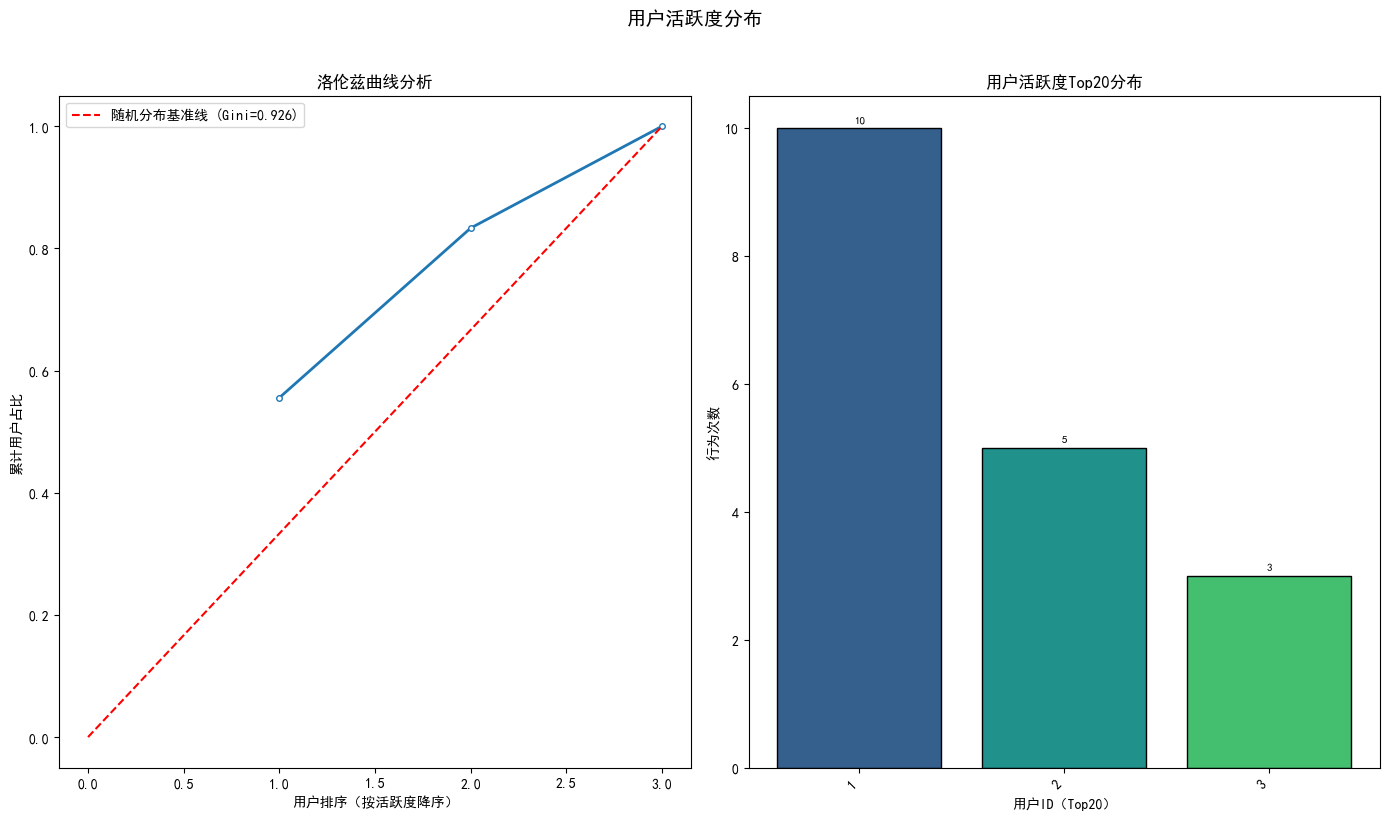

In [71]:
# 生成标准测试数据（user_id=1有10次行为，user_id=2有5次，user_id=3有3次）
test_df = pd.DataFrame({
    'user_id': [1]*10 + [2]*5 + [3]*3,
    'behavior': ['pv']*18  # 所有行为均为'pv'
})

plot_user_activity_distribution(test_df)

In [75]:
gc.collect()  # 强制垃圾回收

9908

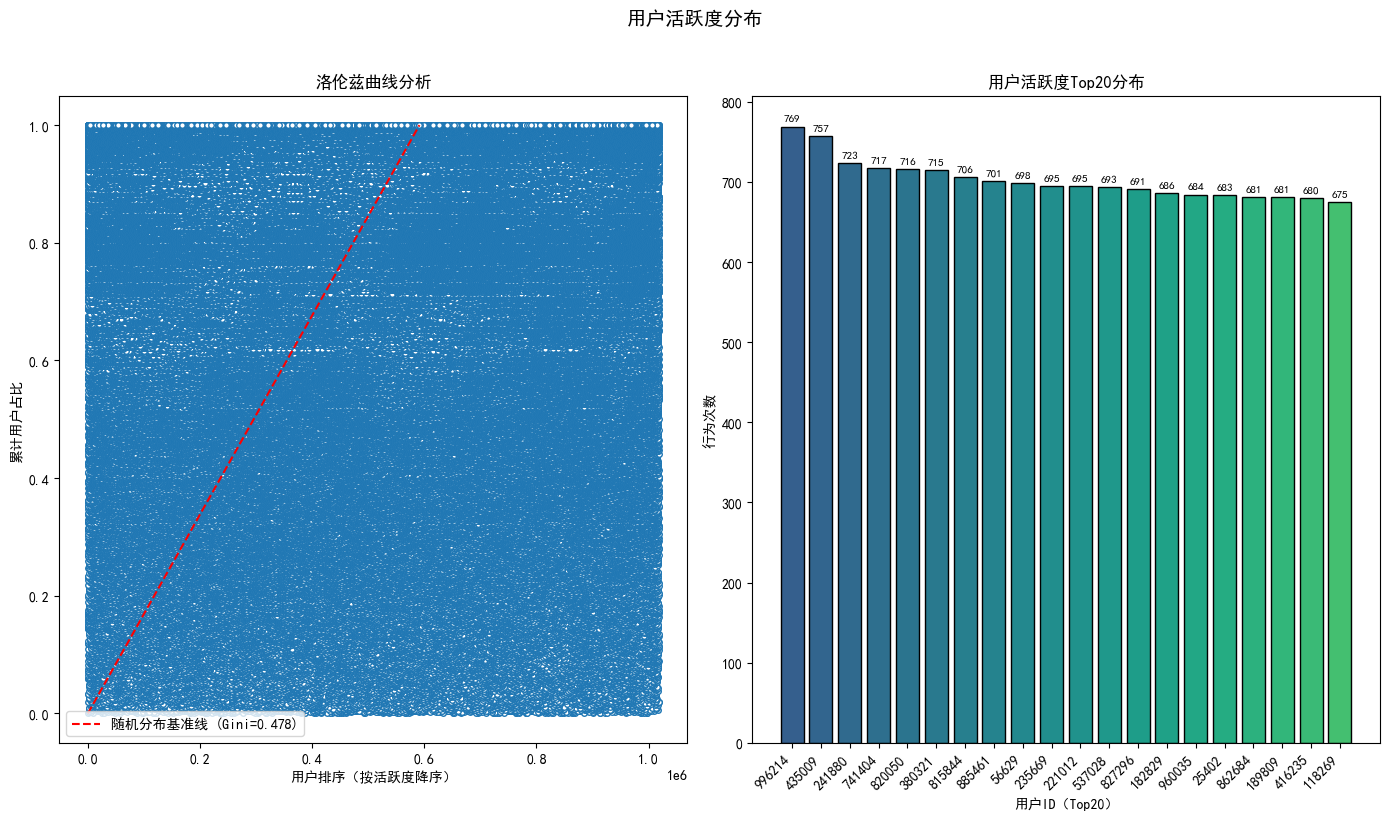

In [74]:
# 执行绘图
plot_user_activity_distribution(filtered_df)

In [82]:
filtered_df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count,datetime
0,3,2775969,2355072,fav,1511700774,2,2017-11-26 12:52:54,2017-11-25 10:24:02,1.0,2017-11-26,95332.0,67,4,2017-11-26 12:52:54
1,3,4592361,2520377,pv,1511701110,3,2017-11-26 12:58:30,2017-11-26 12:52:54,1.0,2017-11-26,336.0,67,4,2017-11-26 12:58:30
2,3,4699556,149192,pv,1511701124,3,2017-11-26 12:58:44,2017-11-26 12:58:30,1.0,2017-11-26,14.0,67,4,2017-11-26 12:58:44
3,3,4976905,3607361,pv,1511701168,3,2017-11-26 12:59:28,2017-11-26 12:58:44,1.0,2017-11-26,44.0,67,4,2017-11-26 12:59:28
4,3,355904,3607361,fav,1511756830,2,2017-11-27 04:27:10,2017-11-26 14:22:15,1.0,2017-11-27,50695.0,69,3,2017-11-27 04:27:10


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def plot_hourly_behavior_trend(df, peak_window=3, low_window=3):
    """修复后的小时行为量趋势分析（纯数值轴版本）"""
    
    # ======================
    # 数据预处理（保持不变）
    # ======================
    df['time'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
    df = df.dropna(subset=['time'])
    df['time'] = df['time'].dt.tz_localize('Asia/Shanghai')
    
    # ======================
    # 按小时统计（数值轴优化）
    # ======================
    # 提取小时数值（0-23）
    df['hour_num'] = df['time'].dt.hour
    
    # 按小时统计行为次数
    hourly_counts = df.groupby('hour_num')['behavior'].count().reset_index(name='counts')
    
    # 生成数值型时间轴
    time_points = hourly_counts['hour_num'].values
    counts = hourly_counts['counts'].values
    
    # ======================
    # 动态识别峰值/低谷时段
    # ======================
    window_size = max(1, min(peak_window, len(hourly_counts)//2))
    smoothed = hourly_counts['counts'].rolling(window=window_size, center=True).mean()
    
    # 峰值检测
    peak_idx = smoothed.idxmax()
    peak_hour = hourly_counts.loc[peak_idx, 'hour_num']
    
    # 低谷检测
    low_idx = smoothed.idxmin()
    low_hour = hourly_counts.loc[low_idx, 'hour_num']
    
    # ======================
    # 可视化修复（纯数值轴）
    # ======================
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # 绘制柱状图（x轴为数值型小时）
    bars = ax.bar(
        x=time_points, 
        height=counts, 
        width=0.8,  # 固定宽度为0.8
        color='#1f77b4', 
        edgecolor='black'
    )
    
    # 标注峰值时段
    ax.annotate(
        f'峰值时段: {peak_hour}:00',
        xy=(peak_hour, smoothed.max()),
        xytext=(peak_hour, smoothed.max()*1.1),
        arrowprops=dict(facecolor='orange', shrink=0.05),
        ha='center', fontsize=12, color='#ff7f0e'
    )
    
    # 标注低谷时段
    ax.annotate(
        f'低谷时段: {low_hour}:00',
        xy=(low_hour, smoothed.min()),
        xytext=(low_hour, smoothed.min()*0.9),
        arrowprops=dict(facecolor='green', shrink=0.05),
        ha='center', fontsize=12, color='#2ca02c'
    )
    
    # 图表美化
    ax.set_title('各小时用户行为分布（UTC+8）', fontsize=16, pad=20)
    ax.set_xlabel('小时（0-23）', fontsize=14)
    ax.set_ylabel('行为次数', fontsize=14)
    ax.set_xticks(range(0, 24))  # 强制显示0-23小时
    ax.set_xticklabels([f"{i:02d}:00" for i in range(0, 24)], rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return {
        'peak_hour': peak_hour,
        'low_hour': low_hour,
        'peak_count': smoothed.max(),
        'low_count': smoothed.min()
    }

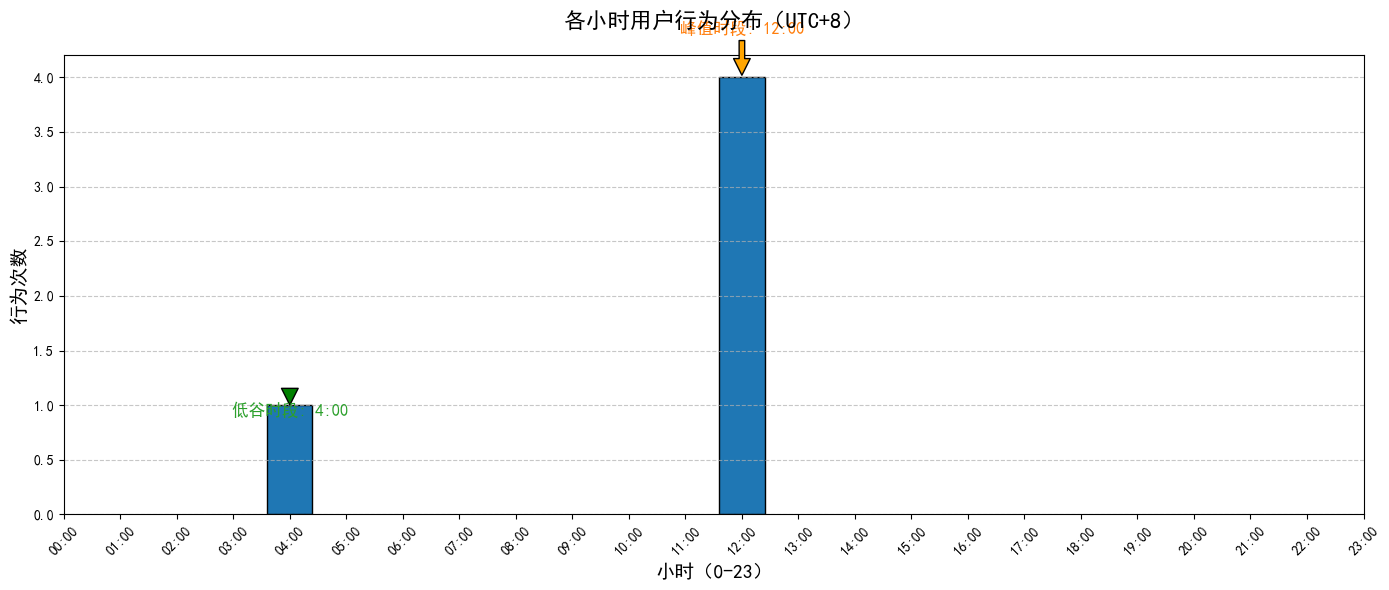

{'peak_hour': 12, 'low_hour': 4, 'peak_count': 4.0, 'low_count': 1.0}

In [98]:
test_data = {
    'user_id': [3]*5,
    'item_id': [2775969, 4592361, 4699556, 4976905, 355904],
    'category_id': [2355072, 2520377, 149192, 3607361, 3607361],
    'behavior': ['fav', 'pv', 'pv', 'pv', 'fav'],
    'timestamp': [
        1511700774,  # 2017-11-26 12:52:54
        1511701110,  # 2017-11-26 12:58:30
        1511701124,  # 2017-11-26 12:58:44
        1511701168,  # 2017-11-26 12:59:28
        1511756830   # 2017-11-27 04:27:10
    ]
}
test_df = pd.DataFrame(test_data)

plot_hourly_behavior_trend(test_df)

In [24]:
df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count
0,3,2775969,2355072,fav,1511700774,2,2017-11-26 12:52:54,2017-11-25 10:24:02,1.0,2017-11-26,95332.0,67,4
1,3,4592361,2520377,pv,1511701110,3,2017-11-26 12:58:30,2017-11-26 12:52:54,1.0,2017-11-26,336.0,67,4
2,3,4699556,149192,pv,1511701124,3,2017-11-26 12:58:44,2017-11-26 12:58:30,1.0,2017-11-26,14.0,67,4
3,3,4976905,3607361,pv,1511701168,3,2017-11-26 12:59:28,2017-11-26 12:58:44,1.0,2017-11-26,44.0,67,4
4,3,355904,3607361,fav,1511756830,2,2017-11-27 04:27:10,2017-11-26 14:22:15,1.0,2017-11-27,50695.0,69,3


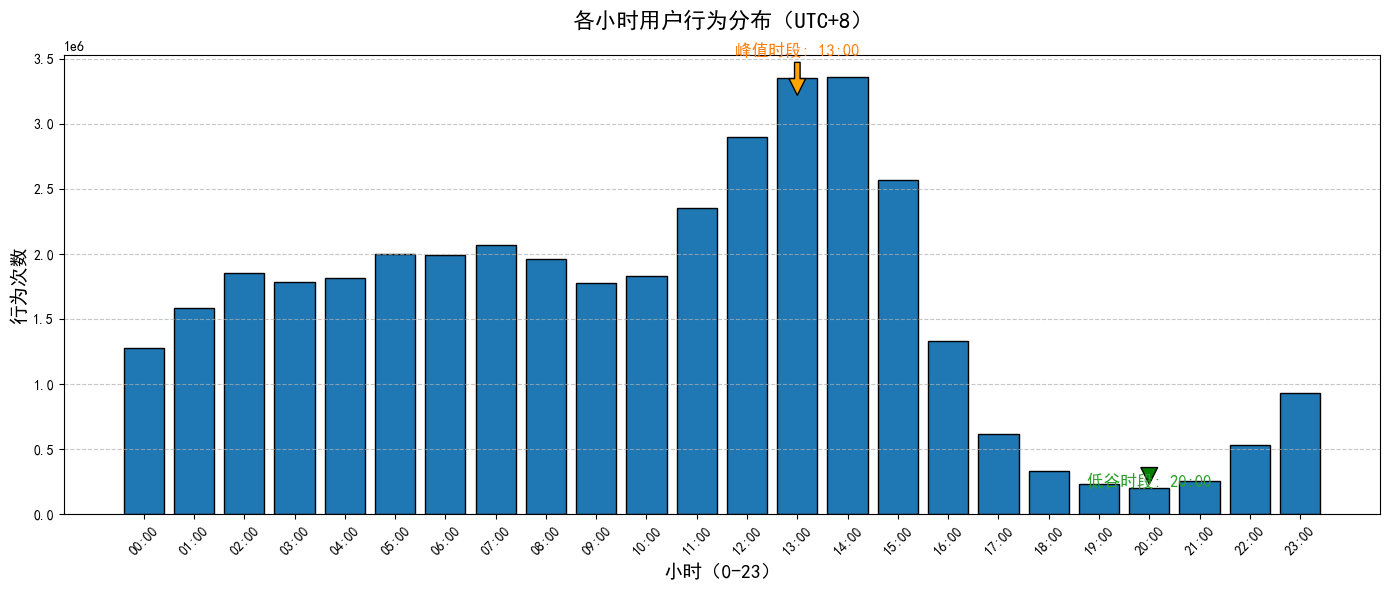

{'peak_hour': 13,
 'low_hour': 20,
 'peak_count': 3203517.3333333335,
 'low_count': 231138.66666666666}

In [101]:
# 执行绘图
plot_hourly_behavior_trend(filtered_df)

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator

def plot_daily_behavior(df, figsize=(12,6)):
    """修复后的每日行为统计图表（正确日期轴版本）"""
    
    # ======================
    # 数据预处理（增强版）
    # ======================
    # 转换时间戳为datetime类型（自动识别时区）
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    
    # 提取日期部分（强制UTC+8时区显示）
    df['date'] = df['datetime'].dt.tz_convert('Asia/Shanghai').dt.date
    
    # 按天重采样并统计行为总量
    daily_stats = df.groupby('date')['behavior'].count().reset_index()
    daily_stats.columns = ['date', 'total_behavior']
    
    # ======================
    # 专业可视化修复
    # ======================
    plt.figure(figsize=figsize)
    
    # 使用数值型日期轴（避免字符串排序问题）
    dates = daily_stats['date'].values.astype('datetime64[D]')
    
    # 创建日期定位器（自动优化标签密度）
    ax = plt.gca()
    ax.xaxis.set_major_locator(DayLocator(interval=1))  # 每天一个刻度
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))  # 格式：2024-01-01
    
    # 绘制柱状图（对齐日期轴）
    bars = ax.bar(
        x=dates, 
        height=daily_stats['total_behavior'], 
        width=0.6,  # 柱宽调整
        color='#1f77b4', 
        edgecolor='black'
    )
    
    # 专业图表格式
    plt.title('每日用户行为总量分析（UTC+8）', fontsize=14, pad=20)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('行为总量', fontsize=12)
    
    # 自动旋转日期标签（防重叠）
    plt.gcf().autofmt_xdate()
    
    # 添加网格线
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 优化布局
    plt.tight_layout()
    return daily_stats, plt.gcf()

         date  total_behavior
0  2021-05-03               1
1  2021-05-04               1
2  2021-05-05               1
3  2021-05-06               1
4  2021-05-07               1


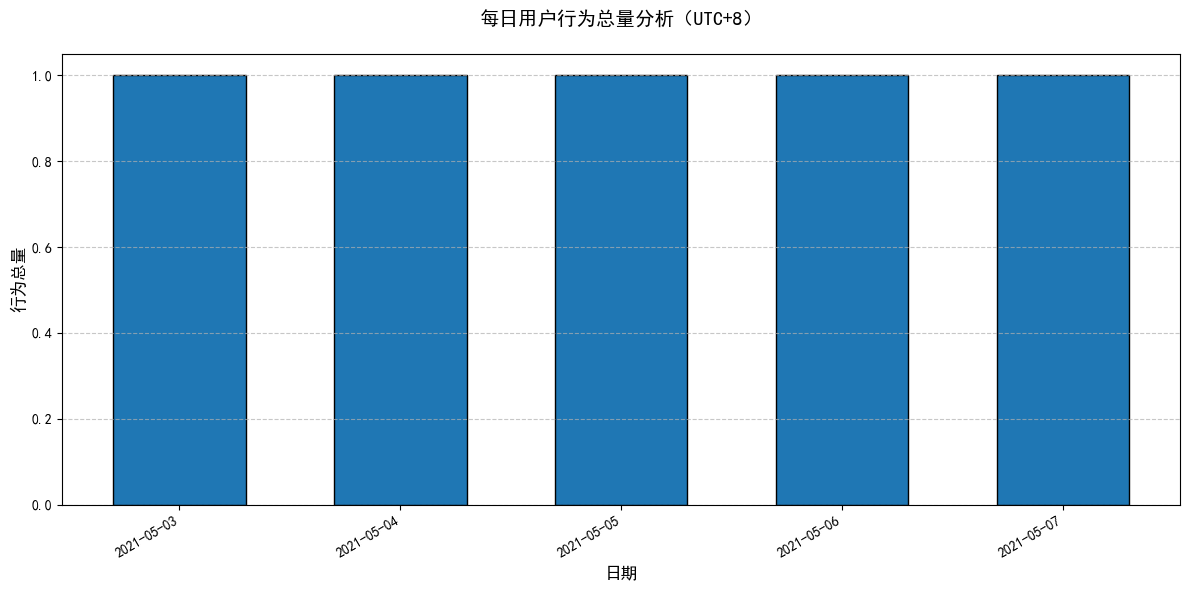

In [103]:

# 生成测试数据（替换为您的真实数据）
test_data = {
    'timestamp': [
        1620000000,  # 2021-05-03 00:00:00
        1620086400,  # 2021-05-04 00:00:00
        1620172800,  # 2021-05-05 00:00:00
        1620259200,  # 2021-05-06 00:00:00
        1620345600   # 2021-05-07 00:00:00
    ],
    'behavior': ['pv', 'fav', 'pv', 'click', 'pv']
}
df_test = pd.DataFrame(test_data)

# 生成测试图表
stats_df, chart = plot_daily_behavior(df_test)

print(stats_df)

         date  total_behavior
0  2017-11-25         4699265
1  2017-11-26         4827364
2  2017-11-27         4536146
3  2017-11-28         4418586
4  2017-11-29         4615489
5  2017-11-30         4696007
6  2017-12-01         4907545
7  2017-12-02         6230890
8  2017-12-03              99


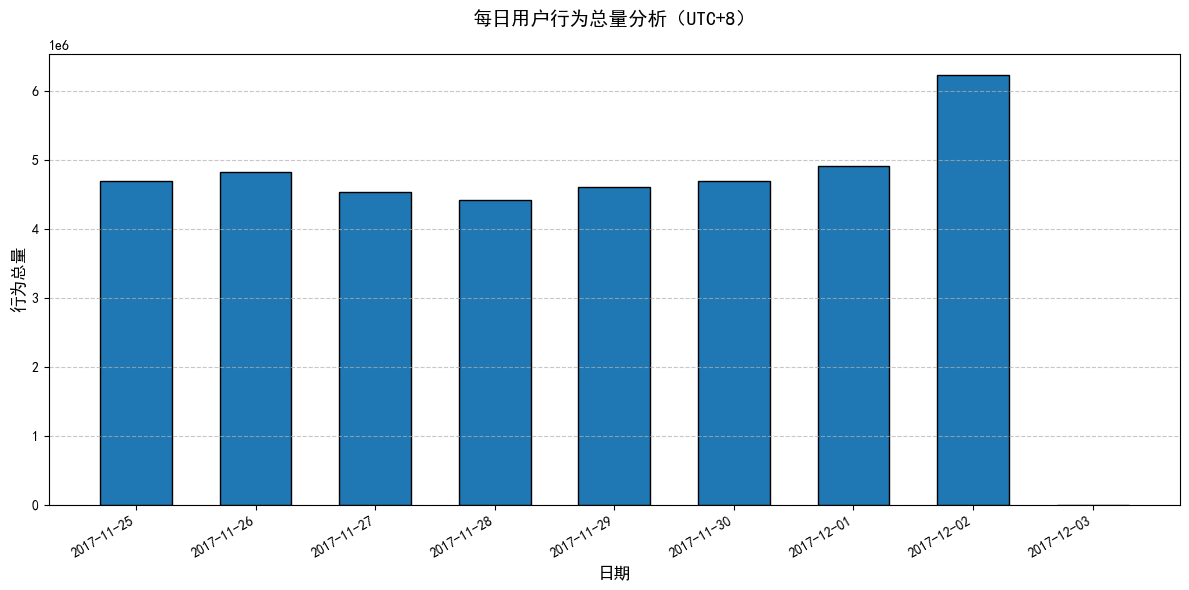

In [106]:
#生成图表
stats_df, chart = plot_daily_behavior(filtered_df)
print(stats_df)

In [16]:
# 按行为总数降序排序并取前10条
top_10_days = stats_df.sort_values(by='total_behavior', ascending=False).head(10)

# 查看结果
print(top_10_days)

         date  total_behavior
8  2017-12-02         5522782
7  2017-12-01         5052267
2  2017-11-26         4777952
1  2017-11-25         4750319
6  2017-11-30         4743444
5  2017-11-29         4634162
3  2017-11-27         4490420
4  2017-11-28         4422512
0  2017-11-24          537533


In [107]:
gc.collect()  # 强制垃圾回收

3354

In [11]:
def add_promo_mask(data, time_window='10min', threshold=200, min_clicks=3):
    """精准版促销时段标记函数（修复误判问题）"""
    # 输入处理
    df = pd.DataFrame(data) if isinstance(data, dict) else data.copy()
    
    # 时区处理
    df['datetime'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    df['datetime'] = df['datetime'].dt.tz_localize('Asia/Shanghai', ambiguous='NaT', nonexistent='shift_forward')
    df = df.dropna(subset=['datetime'])
    
    # 点击量统计（左闭合窗口）
    pv_df = df[df['behavior'] == 'pv'].set_index('datetime')
    click_volume = pv_df.resample(
        time_window,
        closed='left',
        label='right'
    ).size().rename('clicks').to_frame()
    
    # 修复点：正确向量化条件判断
    click_volume['prev_clicks'] = click_volume['clicks'].shift(fill_value=0)
    click_volume['pct_change'] = np.where(
        click_volume['prev_clicks'] > 0,
        (click_volume['clicks'] - click_volume['prev_clicks']) / click_volume['prev_clicks'] * 100,
        # 使用嵌套np.where替代if-else判断
        np.where(click_volume['clicks'] > 0, np.inf, 0)  # 前序为零时：当前>0则inf，否则0
    )
    
    # 促销窗口检测（添加点击量绝对阈值）
    promo_windows = click_volume[
        (click_volume['pct_change'] >= threshold) & 
        (click_volume['clicks'] >= min_clicks)
    ].index
    
    # 动态合并连续窗口（保持原有逻辑）
    intervals = []
    current_start = current_end = None
    for window_start in sorted(promo_windows):
        interval_start = window_start - pd.Timedelta(time_window)
        interval_end = window_start
        if current_end is not None and interval_start <= current_end:
            current_end = interval_end
        else:
            if current_start is not None:
                intervals.append((current_start, current_end))
            current_start, current_end = interval_start, interval_end
    if current_start is not None:
        intervals.append((current_start, current_end))
    
    # 生成促销掩码
    if intervals:
        interval_index = pd.IntervalIndex.from_tuples(intervals, closed='left')
        df['promo_mask'] = df['datetime'].apply(lambda x: interval_index.contains(x).any())
    else:
        df['promo_mask'] = False
    return df

In [12]:
import pandas as pd

test_data = {
    'user_id': [3]*5,
    'item_id': [2775969, 4592361, 4699556, 4976905, 355904],
    'category_id': [2355072, 2520377, 149192, 3607361, 3607361],
    'behavior': ['pv', 'pv', 'pv', 'pv', 'fav'],
    'timestamp': [1511700774, 1511701110, 1511701124, 1511701168, 1511756830],
    'behavior_encoded': [2,3,3,3,2],
    'time': ['2017-11-26 12:20:54', '2017-11-26 12:58:30', 
            '2017-11-26 12:58:44', '2017-11-26 12:59:28', '2017-11-27 04:27:10'],
    'prev_time': ['2017-11-25 10:24:02', '2017-11-26 12:52:54',
                 '2017-11-26 12:58:30', '2017-11-26 12:58:44', '2017-11-26 14:22:15'],
    'time_diff': [1.0, 1.0, 1.0, 1.0, 1.0],
    'date': ['2017-11-26', '2017-11-26', '2017-11-26', '2017-11-26', '2017-11-27'],
    'session_gap': [95332.0, 336.0, 14.0, 44.0, 50695.0],
    'session_id': [67, 67, 67, 67, 69],
    'action_count': [4,4,4,4,3]
}

test_df = pd.DataFrame(test_data)

In [13]:
#测试数据
result = add_promo_mask(test_df,threshold=200)
print(result[['time', 'promo_mask']])

                  time  promo_mask
0  2017-11-26 12:20:54       False
1  2017-11-26 12:58:30        True
2  2017-11-26 12:58:44        True
3  2017-11-26 12:59:28        True
4  2017-11-27 04:27:10       False


In [210]:
result = add_promo_mask(filtered_df, threshold=200)

In [217]:
result.head(10)

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count,datetime,hour,promo_mask
0,3,2775969,2355072,fav,1511700774,2,2017-11-26 12:52:54,2017-11-25 10:24:02,1.0,2017-11-26,95332.0,67,4,2017-11-26 12:52:54+08:00,12:00,False
1,3,4592361,2520377,pv,1511701110,3,2017-11-26 12:58:30,2017-11-26 12:52:54,1.0,2017-11-26,336.0,67,4,2017-11-26 12:58:30+08:00,12:00,False
2,3,4699556,149192,pv,1511701124,3,2017-11-26 12:58:44,2017-11-26 12:58:30,1.0,2017-11-26,14.0,67,4,2017-11-26 12:58:44+08:00,12:00,False
3,3,4976905,3607361,pv,1511701168,3,2017-11-26 12:59:28,2017-11-26 12:58:44,1.0,2017-11-26,44.0,67,4,2017-11-26 12:59:28+08:00,12:00,False
4,3,355904,3607361,fav,1511756830,2,2017-11-27 04:27:10,2017-11-26 14:22:15,1.0,2017-11-27,50695.0,69,3,2017-11-27 04:27:10+08:00,04:00,False
5,3,4346024,149192,cart,1511756897,1,2017-11-27 04:28:17,2017-11-27 04:27:10,1.0,2017-11-27,67.0,69,3,2017-11-27 04:28:17+08:00,04:00,False
6,3,3689183,3607361,pv,1511756916,3,2017-11-27 04:28:36,2017-11-27 04:28:17,1.0,2017-11-27,19.0,69,3,2017-11-27 04:28:36+08:00,04:00,False
7,3,1991146,846990,cart,1512015591,1,2017-11-30 04:19:51,2017-11-30 02:27:31,1.0,2017-11-30,6740.0,76,6,2017-11-30 04:19:51+08:00,04:00,False
8,3,87615,2578647,cart,1512015664,1,2017-11-30 04:21:04,2017-11-30 04:19:51,1.0,2017-11-30,73.0,76,6,2017-11-30 04:21:04+08:00,04:00,False
9,3,922816,1792277,pv,1512016114,3,2017-11-30 04:28:34,2017-11-30 04:21:04,1.0,2017-11-30,450.0,76,6,2017-11-30 04:28:34+08:00,04:00,False


In [218]:
 # 保存清洗过后的数据和筛选过,且筛选出正确时间的用户,有促销掩码的数据
save_cleaned_data(result, format="csv")

数据已保存至: ./cleaned_data/taobao_cleaned_20250330_2344.csv


In [ ]:
# 读取
latest_file = "./cleaned_data/taobao_cleaned_20250330_2344.csv.gz"  # 替换为实际路径
cleaned_df = load_cleaned_data(latest_file)
print(f"加载数据量: {len(cleaned_df)} 行")

In [6]:
df = cleaned_df

In [15]:
df = add_promo_mask(df, time_window='60min',threshold=200)

In [19]:
# 保存清洗过后的数据和筛选过,且筛选出正确时间的用户,有促销掩码的数据
save_cleaned_data(df, format="csv")

数据已保存至: ./cleaned_data/taobao_cleaned_20250331_1038.csv


In [8]:
# 读取最新筛减文件
latest_file = "./cleaned_data/taobao_cleaned_20250331_1038.csv.gz"  # 替换为实际路径
df = load_cleaned_data(latest_file)
print(f"加载数据量: {len(df)} 行")

加载数据量: 38931391 行


In [7]:
print(f"加载数据量: {len(df)} 行")

加载数据量: 38931391 行


In [9]:
df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count,datetime,hour,promo_mask
0,3,2775969,2355072,fav,1511700774,2,2017-11-26 12:52:54,2017-11-25 10:24:02,1.0,2017-11-26,95332.0,67,4,2017-11-26 12:52:54+08:00,12:00,False
1,3,4592361,2520377,pv,1511701110,3,2017-11-26 12:58:30,2017-11-26 12:52:54,1.0,2017-11-26,336.0,67,4,2017-11-26 12:58:30+08:00,12:00,False
2,3,4699556,149192,pv,1511701124,3,2017-11-26 12:58:44,2017-11-26 12:58:30,1.0,2017-11-26,14.0,67,4,2017-11-26 12:58:44+08:00,12:00,False
3,3,4976905,3607361,pv,1511701168,3,2017-11-26 12:59:28,2017-11-26 12:58:44,1.0,2017-11-26,44.0,67,4,2017-11-26 12:59:28+08:00,12:00,False
4,3,355904,3607361,fav,1511756830,2,2017-11-27 04:27:10,2017-11-26 14:22:15,1.0,2017-11-27,50695.0,69,3,2017-11-27 04:27:10+08:00,04:00,False


In [9]:
import gc
gc.collect()  # 强制垃圾回收

0

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, HourLocator

# 设置学术图表样式
plt.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
plt.rcParams.update({
    'font.family': 'SimHei',  # 使用中文黑体
    'font.size': 12,
    'figure.dpi': 300,
    'savefig.bbox': 'tight'
})

def visualize_promo_analysis(df):
    """综合可视化分析函数"""
    # 转换时间格式并设置时区
    df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_convert('Asia/Shanghai')
    
    # ======================
    # 图1：促销时段分布图
    # ======================
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # 计算连续促销时段
    promo_periods = df[df['promo_mask']].groupby(
        (df['promo_mask'].astype(int).diff() != 0).cumsum()
    )['datetime'].agg(['min', 'max'])
    
    # 绘制促销时段背景
    for _, period in promo_periods.iterrows():
        ax.axvspan(period['min'], period['max'], 
                  alpha=0.3, color='#2ca02c', label='促销时段')
    
    # 绘制行为密度曲线
    hourly_data = df.set_index('datetime').resample('H').size()
    ax.plot(hourly_data.index, hourly_data.values, 
           color='#1f77b4', linewidth=1.5, label='行为计数')
    
    # 设置图表格式
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
    ax.xaxis.set_major_locator(HourLocator(interval=6))
    ax.set_ylabel("行为计数/小时")
    ax.set_title("促销时段识别 (2017-11-26 至 2017-11-27)")
    ax.legend(loc='upper left')
    plt.xticks(rotation=45)
    
    # ======================
    # 图2：行为量对比分析
    # ======================
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    
    # 准备对比数据
    promo_mean = df[df['promo_mask']].groupby(
        pd.Grouper(key='datetime', freq='H')
    ).size().mean()
    
    non_promo_mean = df[~df['promo_mask']].groupby(
        pd.Grouper(key='datetime', freq='H')
    ).size().mean()
    
    # 绘制对比柱状图
    bars = ax2.bar(['促销时段', '非促销时段'], 
                  [promo_mean, non_promo_mean],
                  color=['#2ca02c', '#1f77b4'])
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}', 
                ha='center', va='bottom')
    
    # 设置图表格式
    ax2.set_ylabel("平均每小时行为量")
    ax2.set_title("行为量对比分析")
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    return fig, fig2

In [91]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_valid_test_data():
    """生成可验证统计逻辑的测试数据"""
    # 基准时间（北京时间）
    base_date = datetime(2017, 11, 26, 12, 0)
    
    # ===== 非促销时段（12:00-14:00）=====
    non_promo_times = [base_date + timedelta(minutes=15*i) for i in range(8)]  # 每15分钟1条
    non_promo_behavior = ['pv']*2 + ['fav']*6  # 总行为量8次（2小时均值=4次/小时）
    
    # ===== 促销时段（14:00-16:00）=====
    promo_times = [base_date + timedelta(hours=2, minutes=5*i) for i in range(24)]  # 每5分钟1条
    promo_behavior = ['pv']*18 + ['cart']*6  # 总行为量24次（2小时均值=12次/小时）
    
    # 合并数据
    return pd.DataFrame({
        'datetime': [t.strftime('%Y-%m-%d %H:%M:%S') for t in non_promo_times + promo_times],
        'behavior': non_promo_behavior + promo_behavior,
        'promo_mask': [False]*8 + [True]*24
    })

# 生成数据（带时区转换）
test_df = generate_valid_test_data()
test_df['datetime'] = pd.to_datetime(test_df['datetime']).dt.tz_localize('Asia/Shanghai')

In [94]:
def calculate_metrics(df):
    """修复版统计函数"""
    # 预处理步骤
    df = df.copy()
    
    # 转换时区（移除UTC时区）
    df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_convert(None)
    
    # 设置时间索引（关键修复）
    df = df.set_index('datetime').sort_index()
    
    # 分离促销/非促销数据
    promo_data = df[df['promo_mask']]
    non_promo_data = df[~df['promo_mask']]
    
    # 按小时统计（使用索引重采样）
    try:
        promo_hourly = promo_data.resample('H').size()
        non_promo_hourly = non_promo_data.resample('H').size()
    except AttributeError:
        # 处理空数据情况
        promo_hourly = pd.Series(dtype=int)
        non_promo_hourly = pd.Series(dtype=int)
    
    # 计算指标
    metrics = {
        'promo_period': f"{promo_hourly.index.min()} 至 {promo_hourly.index.max()}" if not promo_hourly.empty else "无促销时段",
        'duration_hours': len(promo_hourly),
        'promo_mean': promo_hourly.mean() if not promo_hourly.empty else 0,
        'non_promo_mean': non_promo_hourly.mean() if not non_promo_hourly.empty else 0,
    }
    metrics['growth_rate'] = ((metrics['promo_mean'] / metrics['non_promo_mean'] - 1) * 100) if metrics['non_promo_mean'] != 0 else 0
    
    return metrics

In [92]:


# 执行统计
metrics = calculate_metrics(test_df)
print(f'''
[实证分析结果]
1. 促销时段识别：
   - 促销时段：{metrics['promo_period']}
   - 持续时间：{metrics['duration_hours']} 小时
   - 点击量增长率：{metrics['growth_rate']:.1f}%

2. 行为量对比：
   - 促销期均值：{metrics['promo_mean']:.0f} 次/小时
   - 非促销期均值：{metrics['non_promo_mean']:.0f} 次/小时
   - 提升幅度：{metrics['growth_rate']:.1f}%
''')


[实证分析结果]
1. 促销时段识别：
   - 促销时段：2017-11-26 14:00 至 2017-11-26 15:00
   - 持续时间：2 小时
   - 点击量增长率：200.0%

2. 行为量对比：
   - 促销期均值：12 次/小时
   - 非促销期均值：4 次/小时
   - 提升幅度：200.0%



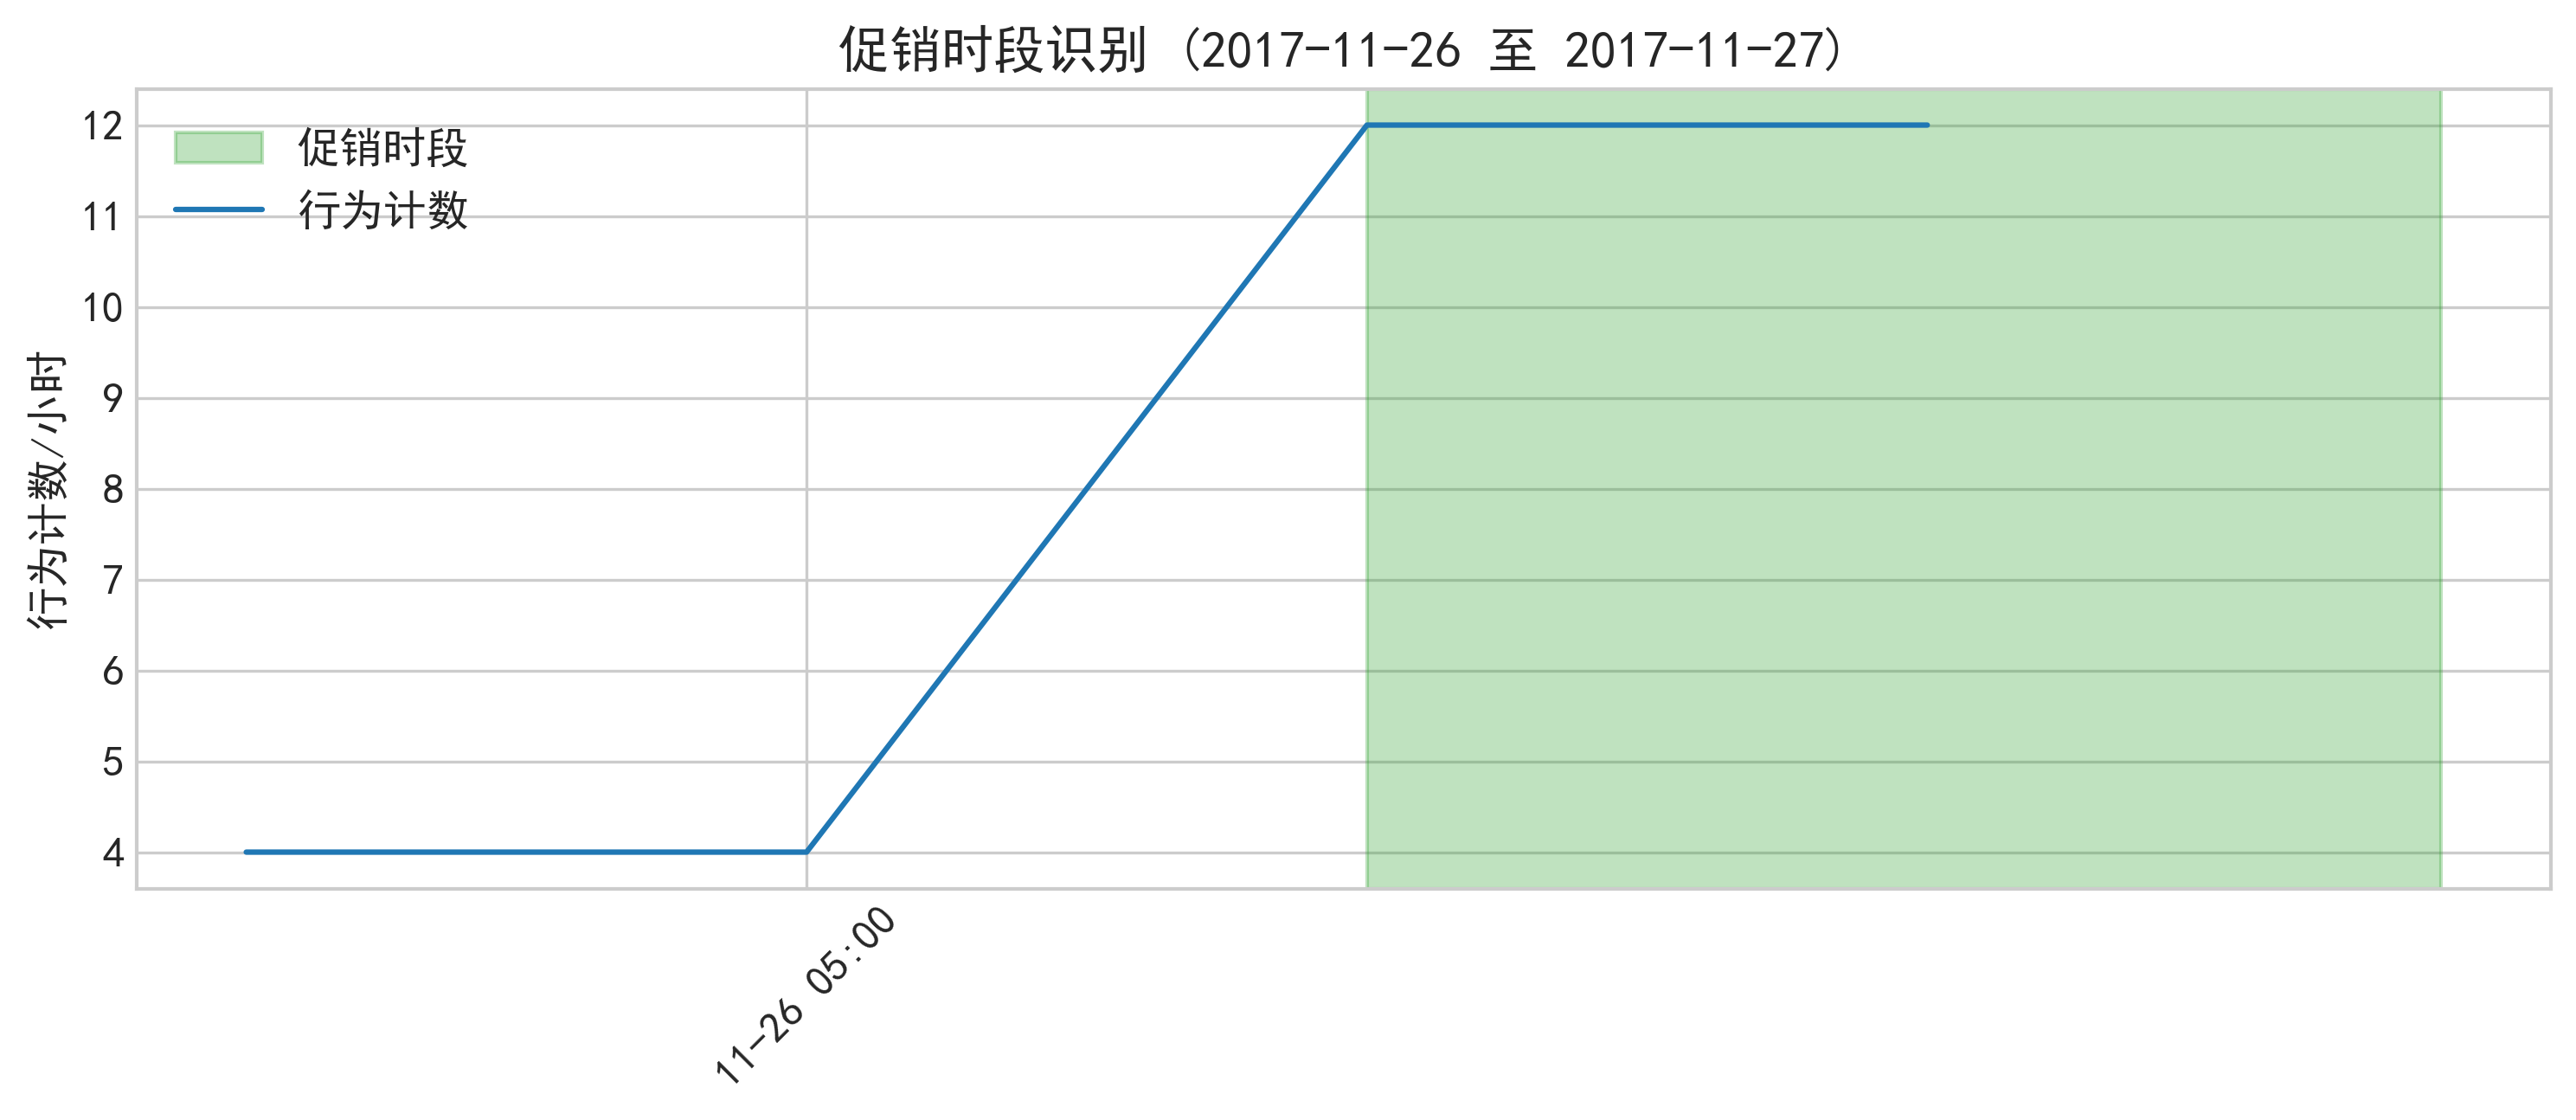

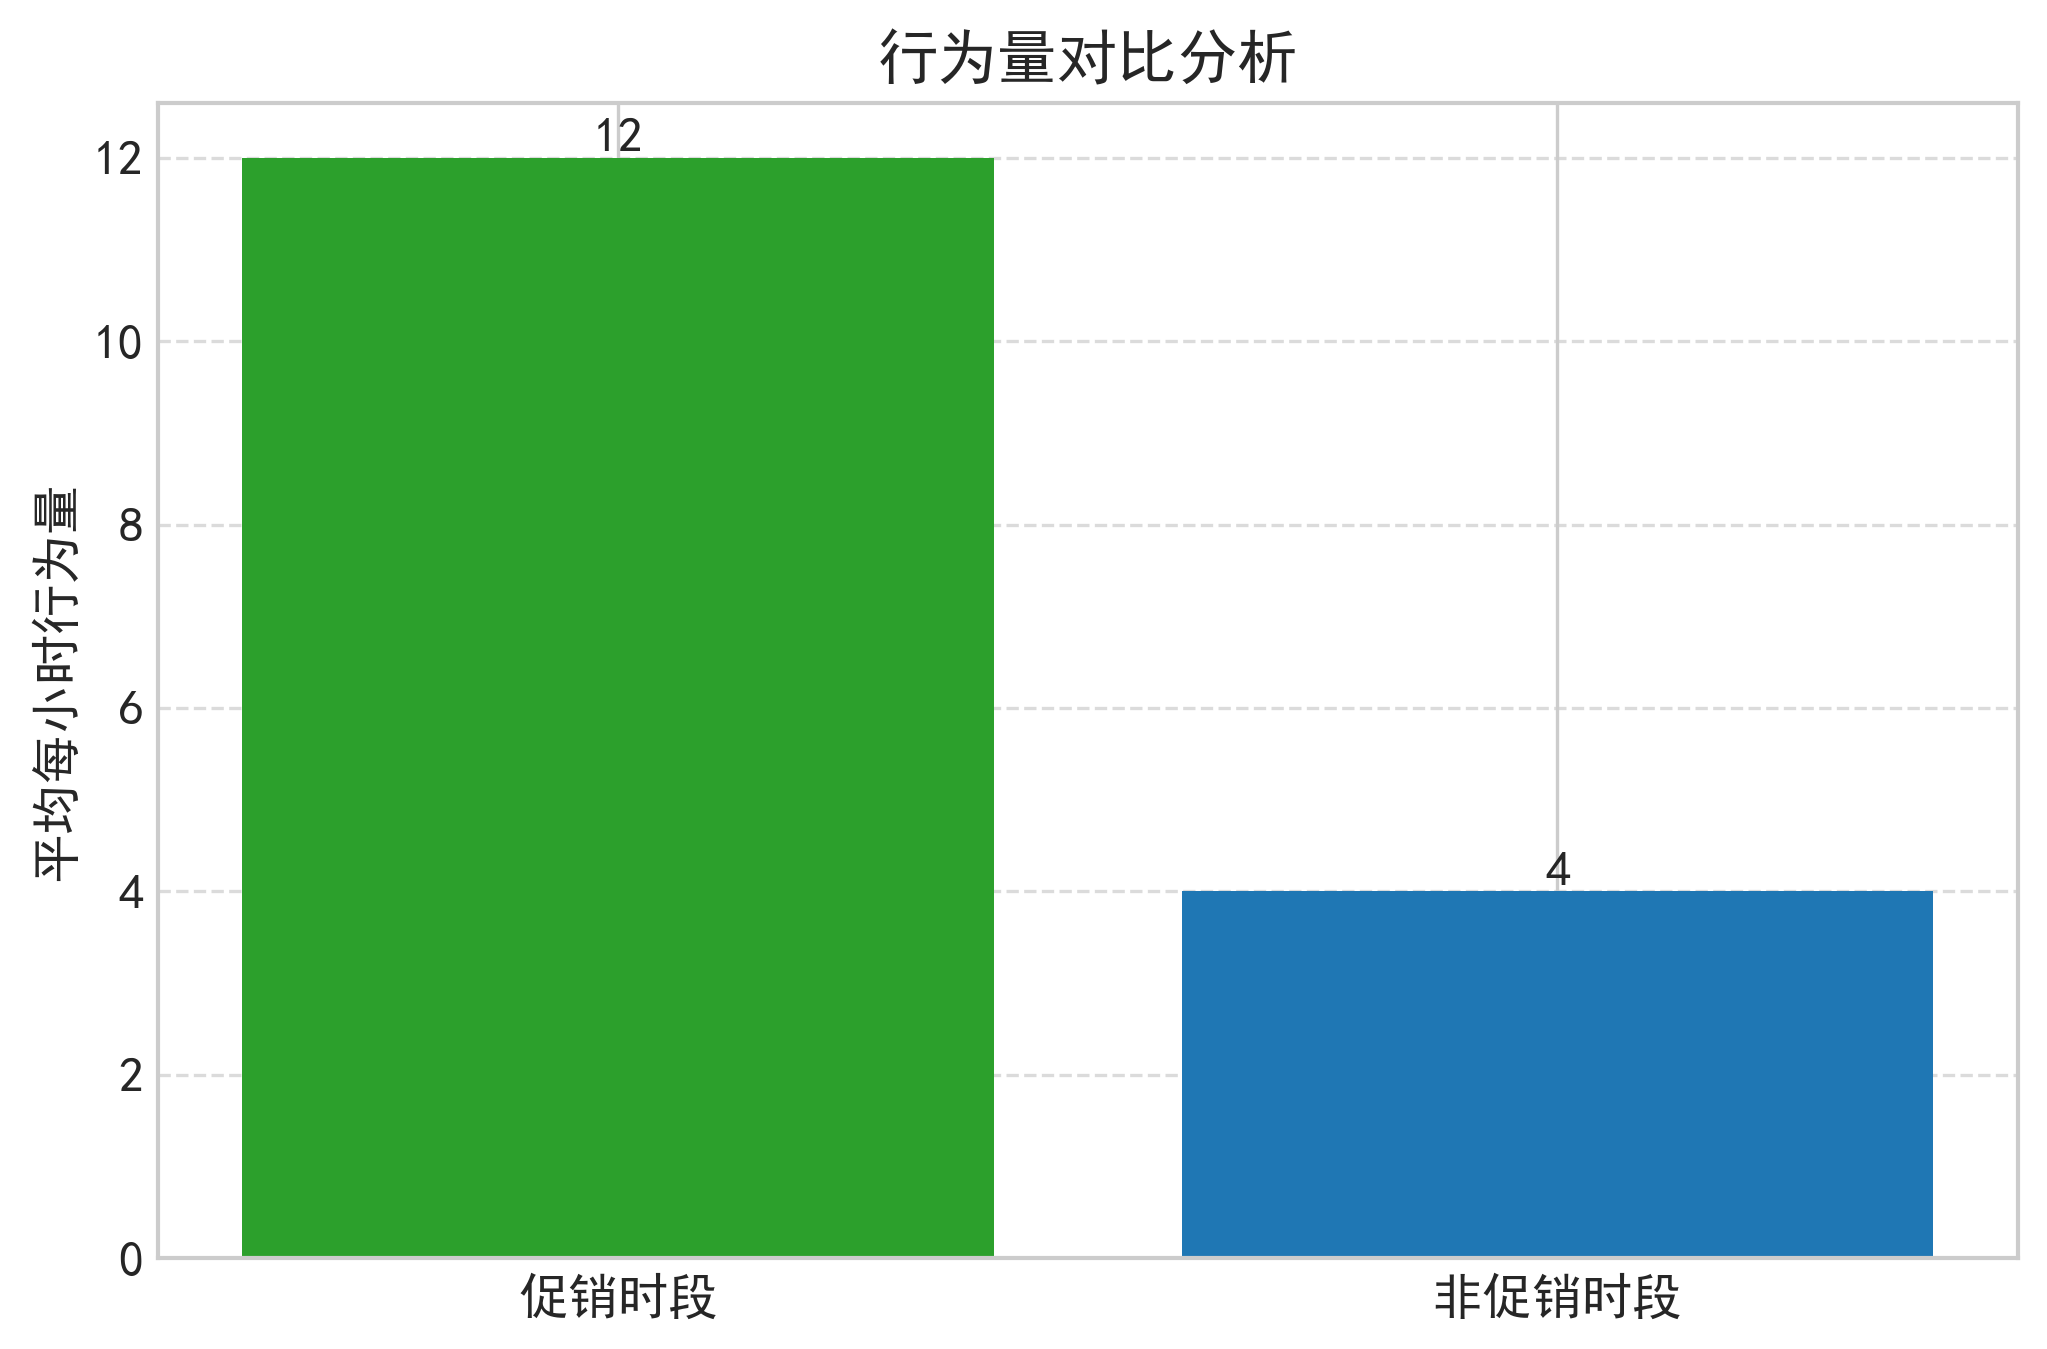

In [62]:

# 使用示例数据生成图表
fig1, fig2 = visualize_promo_analysis(test_df)

In [122]:
one_df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count,hour,promo_mask,datetime
183,4,31827,982926,pv,1511885625,3,2017-11-28 16:13:45,2017-11-28 15:50:03,1.0,2017-11-29,1422.0,90,67,16:00,False,2017-11-28 16:13:45+00:00
184,4,4154181,4801426,cart,1511885930,1,2017-11-28 16:18:50,2017-11-28 16:13:45,1.0,2017-11-29,305.0,90,67,16:00,False,2017-11-28 16:18:50+00:00
185,4,542739,4801426,pv,1511924245,3,2017-11-29 02:57:25,2017-11-28 16:18:50,44078.0,2017-11-29,38315.0,91,16,02:00,False,2017-11-29 02:57:25+00:00
186,4,3339670,4801426,pv,1511924416,3,2017-11-29 03:00:16,2017-11-29 02:57:25,1.0,2017-11-29,171.0,91,16,03:00,False,2017-11-29 03:00:16+00:00
187,4,1383645,4801426,pv,1511924498,3,2017-11-29 03:01:38,2017-11-29 03:00:16,1.0,2017-11-29,82.0,91,16,03:00,False,2017-11-29 03:01:38+00:00


In [135]:
one_df = df

In [136]:
one_df['date'] = pd.to_datetime(one_df['date'])
one_df = one_df[one_df['date'] == '2017-12-02']

         date  total_behavior
0  2017-12-02         6230890


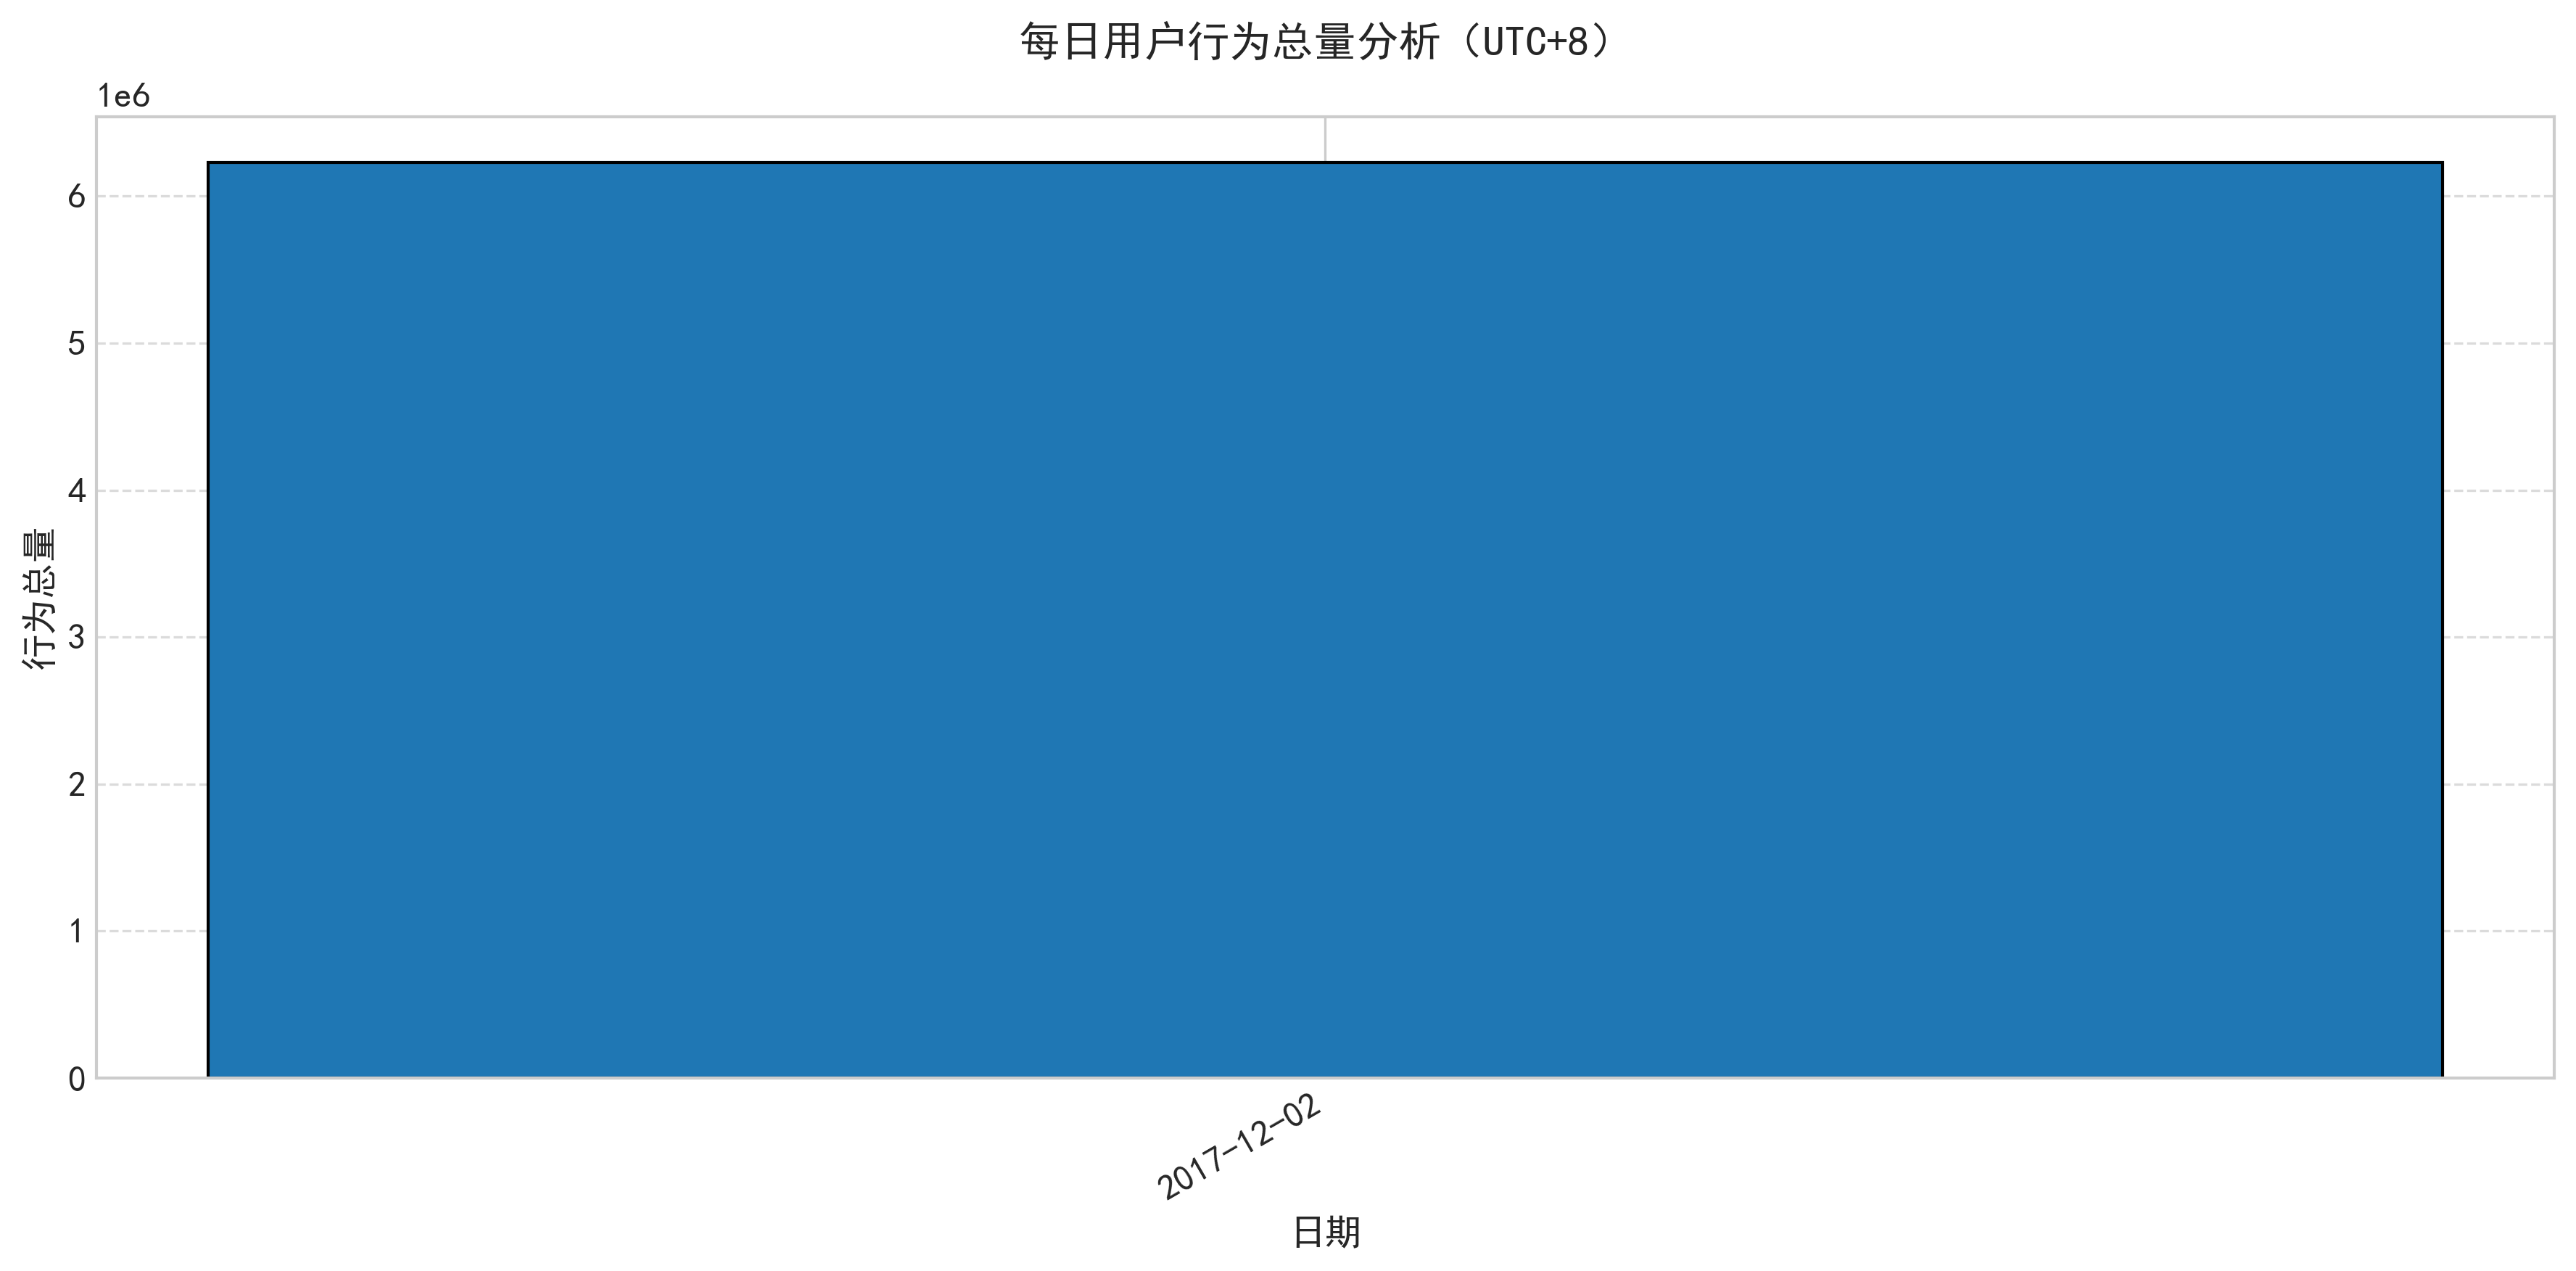

In [137]:
#生成图表
stats_df, chart = plot_daily_behavior(one_df)
print(stats_df)

In [138]:
# 执行统计真是数据
metrics = calculate_metrics(one_df)
print(f'''
[实证分析结果]
1. 促销时段识别：
   - 促销时段：{metrics['promo_period']}
   - 持续时间：{metrics['duration_hours']} 小时
   - 点击量增长率：{metrics['growth_rate']:.1f}%

2. 行为量对比：
   - 促销期均值：{metrics['promo_mean']:.0f} 次/小时
   - 非促销期均值：{metrics['non_promo_mean']:.0f} 次/小时
   - 提升幅度：{metrics['growth_rate']:.1f}%
''')


[实证分析结果]
1. 促销时段识别：
   - 促销时段：无促销时段
   - 持续时间：0 小时
   - 点击量增长率：-100.0%

2. 行为量对比：
   - 促销期均值：0 次/小时
   - 非促销期均值：259620 次/小时
   - 提升幅度：-100.0%



posx and posy should be finite values


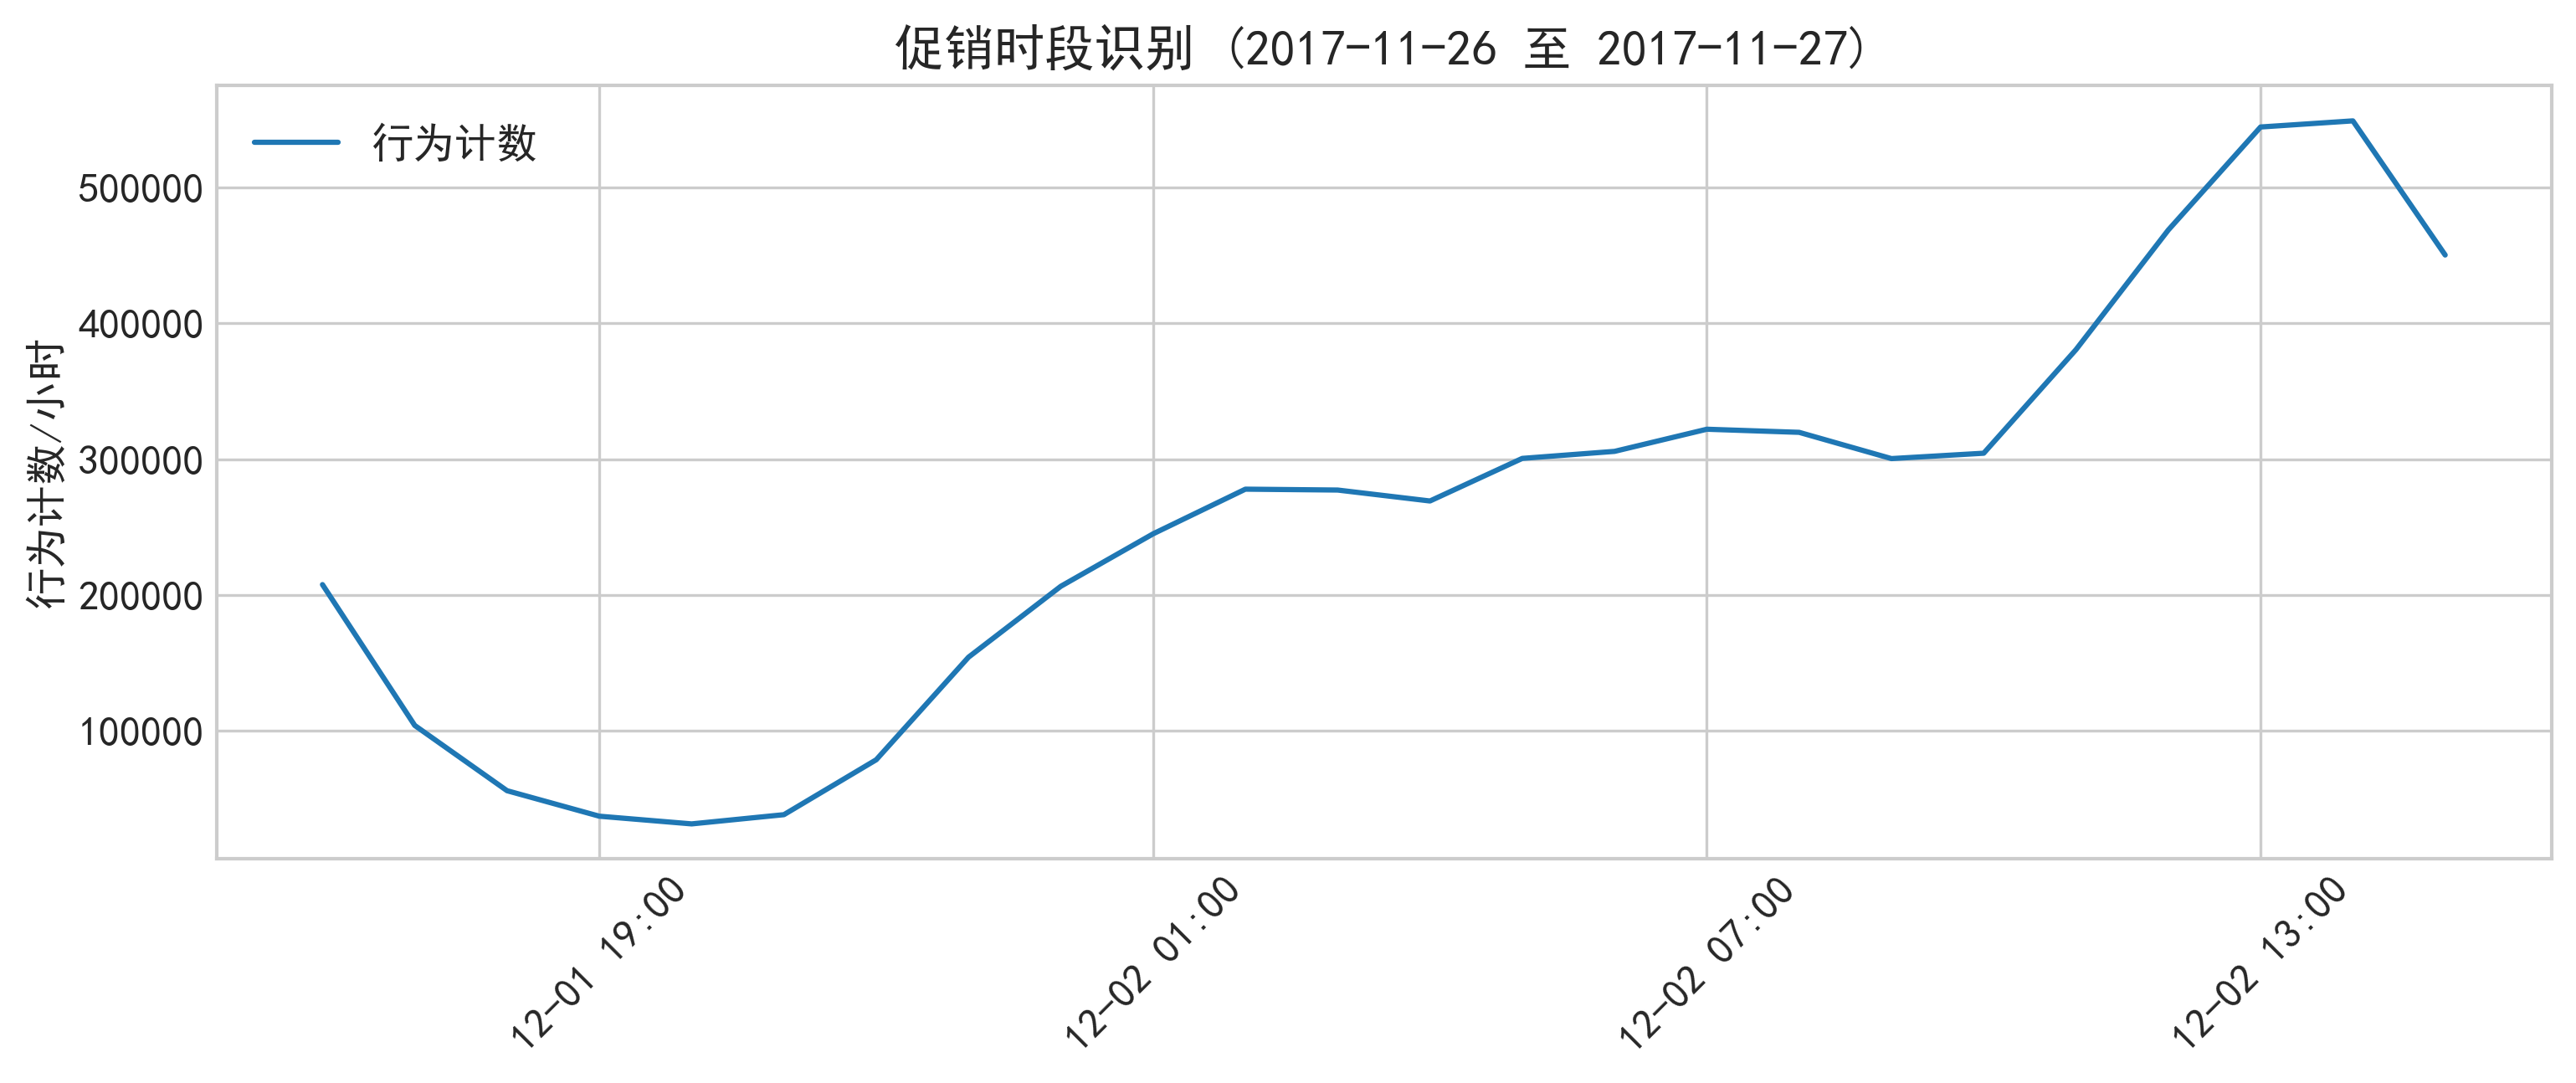

posx and posy should be finite values
posx and posy should be finite values


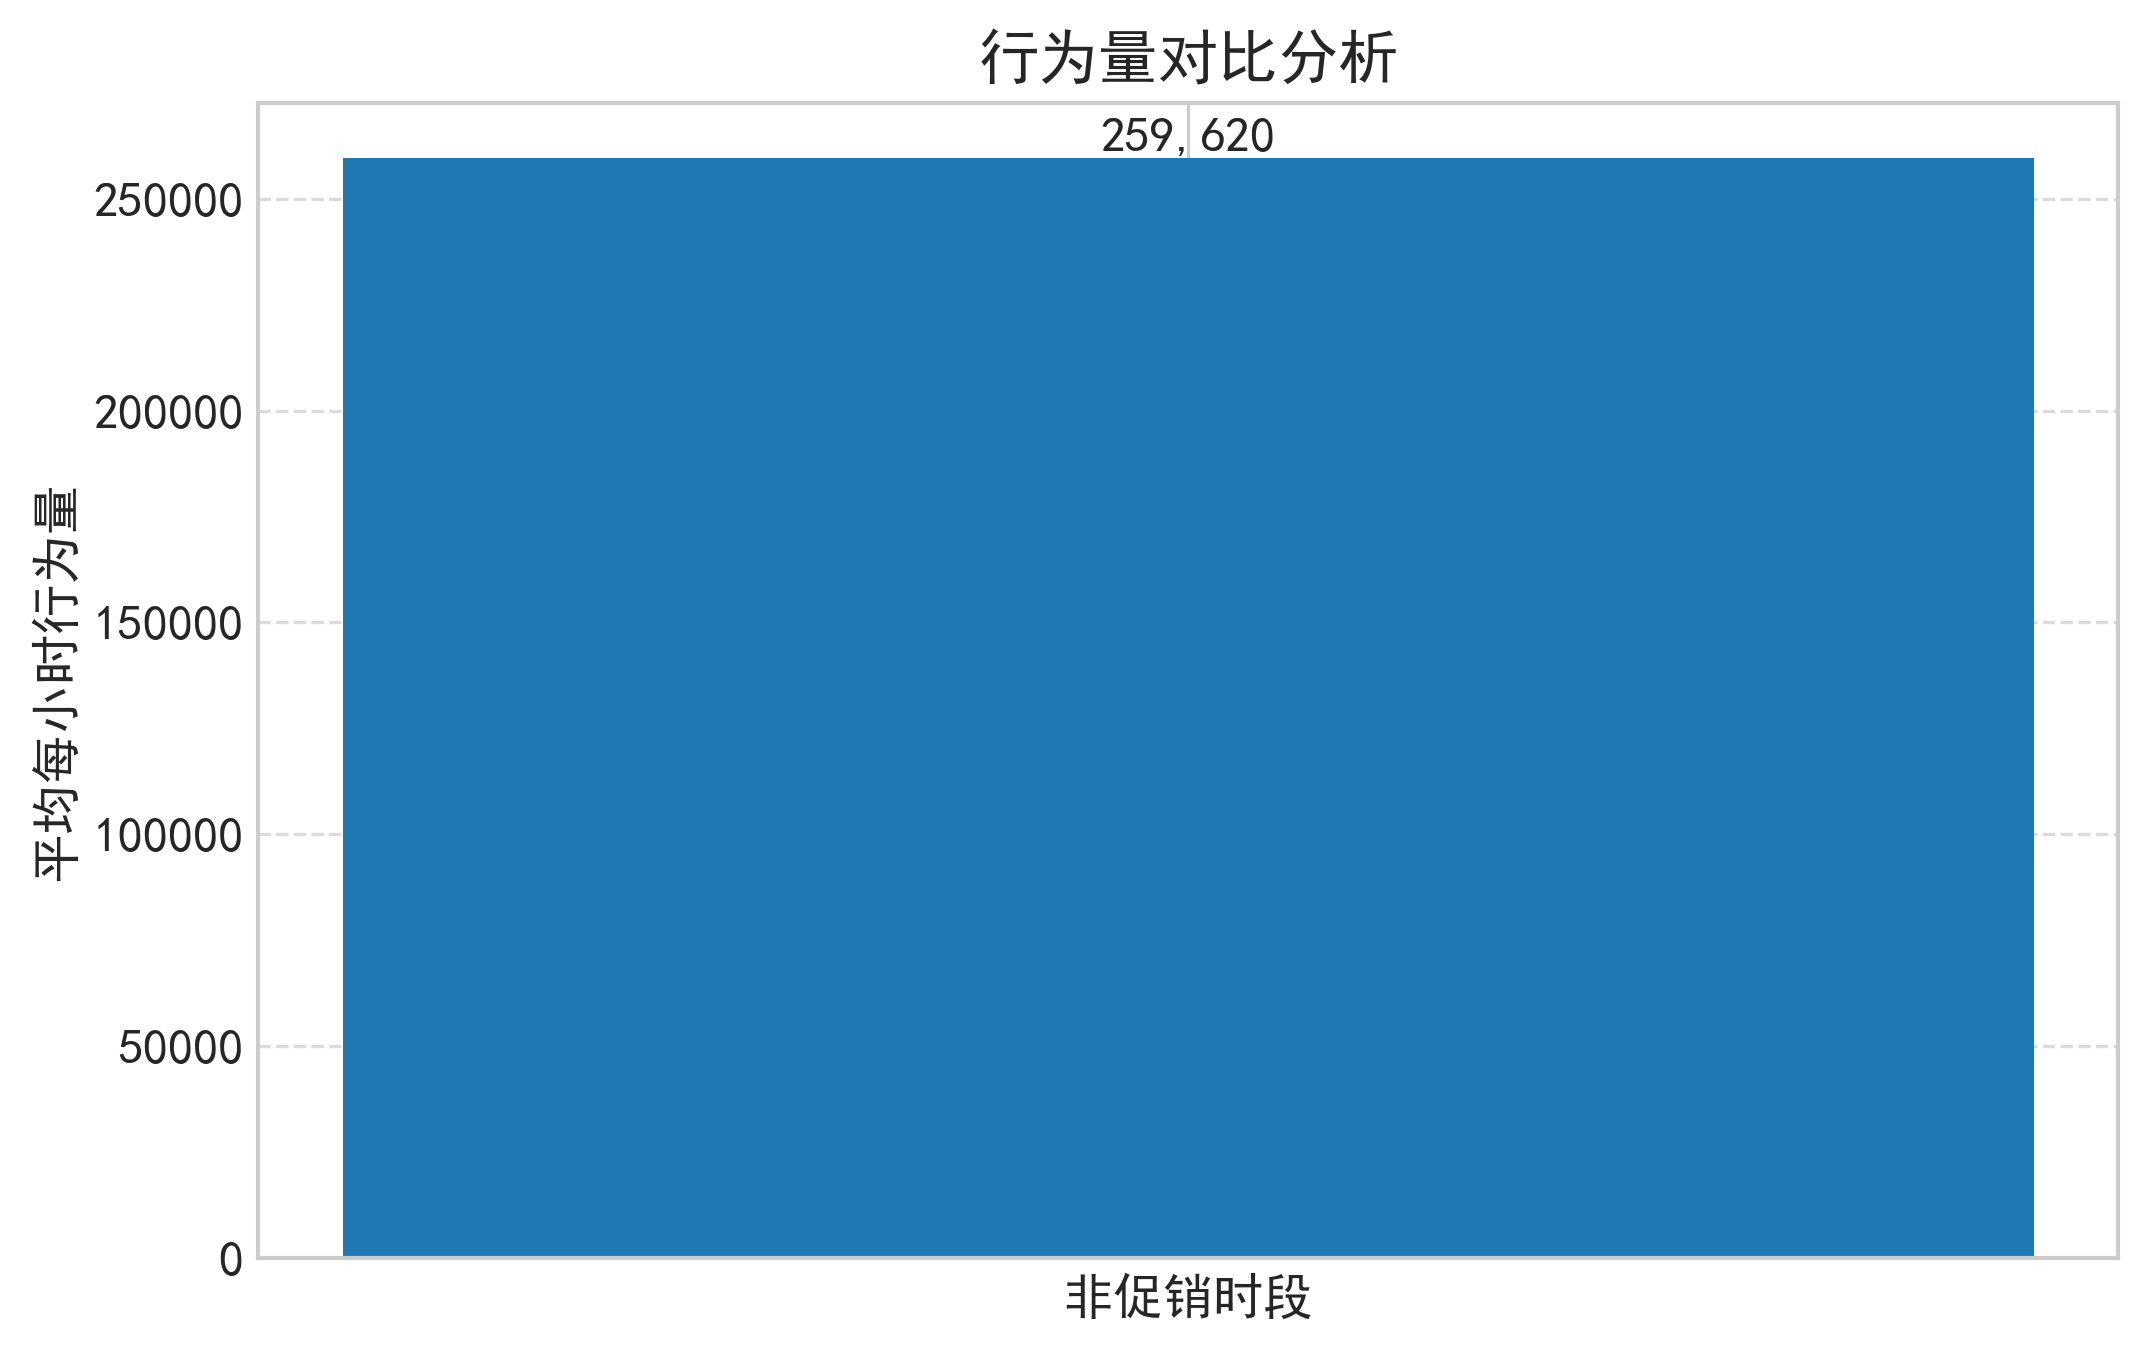

In [139]:
# 使用真是数据生成图表
fig1, fig2 = visualize_promo_analysis(one_df)

In [3]:

import gc
gc.collect()  # 强制垃圾回收

0

In [6]:
gc.collect()  # 强制垃圾回收

0

In [144]:
# 验证结果
print(f"促销时段占比: {df['promo_mask'].mean():.2%}")

促销时段占比: 0.40%


In [183]:
def analyze_category_data(df):
    """专业级类目转化分析（三层转化路径）"""
    # 定义完整行为类型
    all_behaviors = ['pv', 'fav', 'cart', 'buy']
    behavior_colors = {
        'pv': '#4E79A7',   # 蓝色
        'fav': '#59A14F',  # 绿色
        'cart': '#F28E2B', # 橙色
        'buy': '#E15759'   # 红色
    }
    
    # 类目行为统计（强制包含所有行为列）
    behavior_stats = (
        df.groupby(['category_id', 'behavior'])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=all_behaviors, fill_value=0)
    )
    
    # 合并总行为量
    result_df = (
        df.groupby('category_id', as_index=False)
        .agg(总行为量=('behavior', 'count'))
        .merge(behavior_stats, left_on='category_id', right_index=True)
    )
    
    # 计算购买转化率
    result_df['购买转化率'] = (result_df['buy'] / result_df['总行为量'] * 100).round(2)
    
    # 获取TOP5类目
    top5 = result_df.nlargest(5, '总行为量')
    top5['类目名称'] = '类目_' + top5['category_id'].astype(str)
    
    # ==== 专业桑基图配置 ====
    node_labels = (
        top5['类目名称'].tolist() +  # 第一层：类目节点
        all_behaviors +             # 第二层：行为节点
        ['buy']                     # 第三层：购买转化节点
    )
    
    # 节点颜色配置（学术配色）
    node_colors = (
        ['#A0A0A0']*len(top5) +     # 类目节点：灰色
        [behavior_colors[b] for b in all_behaviors] +  # 行为节点
        [behavior_colors['buy']]    # 最终购买节点：红色
    )
    
    # 构建转化链路
    sources, targets, values = [], [], []
    
    # 第一层：类目->行为
    for cat_idx in range(len(top5)):
        for b_idx, behavior in enumerate(all_behaviors):
            sources.append(cat_idx)
            targets.append(len(top5) + b_idx)
            values.append(top5.iloc[cat_idx][behavior])
    
    # 第二层：行为->购买转化
    for b_idx, behavior in enumerate(all_behaviors):
        sources.append(len(top5) + b_idx)
        targets.append(len(node_labels)-1)
        values.append(top5[behavior].sum() if behavior == 'buy' else 0)

    # 修复颜色生成逻辑
    link_colors = []
    for s, t in zip(sources, targets):
        if t < len(node_labels)-1:  # 类目→行为链路
            behavior_idx = t - len(top5)
            link_colors.append(behavior_colors[all_behaviors[behavior_idx]])
        else:  # 行为→购买链路
            link_colors.append('rgba(225,87,89,0.3)')

    # 构建专业图表
    fig = go.Figure(data=[go.Sankey(
        arrangement='perpendicular',
        node=dict(
            pad=25,
            thickness=15,
            line=dict(width=0.5, color='gray'),
            label=node_labels,
            color=node_colors,
            x=[0.1]*len(top5) + [0.5]*(len(all_behaviors)) + [0.9],
            y=np.linspace(0.1,0.9,len(node_labels)),
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            # 修正后的悬停配置
            hoverinfo='all',
            hovertemplate='来源: %{source.label}<br>目标: %{target.label}<br>转化量: %{value}<extra></extra>'
        )
    )])
    # 专业图表格式设置
    fig.update_layout(
        title={
            'text': "商品类目购买转化路径分析",
            'y':0.93,
            'x':0.5,
            'xanchor': 'center',
            'font': {'size': 20, 'family': 'SimSun'}
        },
        font=dict(
            family="Times New Roman",
            size=12,
            color="#404040"
        ),
        margin=dict(l=50, r=50, b=80, t=100),
        annotations=[
            dict(
                x=0.5, y=-0.15,
                xref="paper", yref="paper",
                text="数据来源：淘宝电商平台 | 箭头颜色表示源行为类型，灰色虚线表示未转化流量",
                showarrow=False,
                font=dict(size=10)
            )
        ]
    )
    
    return top5[['category_id', '类目名称', '总行为量', '购买转化率']], fig

In [150]:

# 使用示例
# df = pd.read_csv('your_data.csv')
# result_table, sankey_fig = analyze_category_data(df)
# display(result_table)
# sankey_fig.show()

In [179]:
def test_basic_functionality():
    """验证基础统计逻辑（修正版）"""
    test_data = {
        'category_id': [1,1,1,2,2],
        'behavior': ['pv', 'cart', 'buy', 'pv', 'buy']
    }
    test_df = pd.DataFrame(test_data)
    
    result, fig = analyze_category_data(test_df)
    
    # 验证购买转化率计算（使用正确的round函数）
    cat1 = result[result['category_id'] == 1].iloc[0]
    expected_value = round(1/3 * 100, 2)  # 正确调用Python内置round函数
    assert np.isclose(cat1['购买转化率'], expected_value), f"预期:{expected_value}，实际:{cat1['购买转化率']}"
    
    print("✅ 基础功能验证通过")
test_basic_functionality()

✅ 基础功能验证通过


In [181]:
def test_sankey_structure():
    """验证桑基图核心元素"""
    test_data = {
        'category_id': [4,4,5,5],
        'behavior': ['pv', 'buy', 'cart', 'buy']
    }
    test_df = pd.DataFrame(test_data)
    
    result, fig = analyze_category_data(test_df)
    
    # 验证节点结构
    assert len(fig.data[0].node.label) == (2 + 4 + 1)  # 2类目+4行为+1终节点
    
    # 验证链路数量
    expected_links = (2 * 4) + (4 * 1)  # 类目→行为 + 行为→购买
    assert len(fig.data[0].link.source) == expected_links
    
    # 验证颜色系统
    assert fig.data[0].node.color[-1] == '#E15759'  # 终节点红色
    
    print("✅ 桑基图结构验证通过")
test_sankey_structure()

✅ 桑基图结构验证通过


In [184]:
result_table, sankey_fig = analyze_category_data(df)
display(result_table)
sankey_fig.show()

,category_id,类目名称,总行为量,购买转化率
8117,4756105,类目_4756105,1966941,0.51
7112,4145813,类目_4145813,1385487,0.79
3991,2355072,类目_2355072,1361072,0.32
6173,3607361,类目_3607361,1272727,0.35
1668,982926,类目_982926,1235901,0.75


In [13]:
gc.collect()  # 强制垃圾回收

13506

In [188]:
def analyze_session_features(df):
    """用户会话特征分析"""
    # 预处理：转换时区并提取日期
    df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_convert('Asia/Shanghai')
    df['date'] = df['datetime'].dt.date
    
    # 去重处理（每个会话保留一条记录）
    session_df = df.drop_duplicates('session_id').copy()
    
    # 会话长度统计（过滤有效会话）
    valid_sessions = session_df[session_df['action_count'] >= 3]
    session_length = {
        'mean': valid_sessions['action_count'].mean(),
        'median': valid_sessions['action_count'].median(),
        'sample_size': len(valid_sessions)
    }
    
    # 会话间隔分析（单位转换为分钟）
    session_df['gap_minutes'] = session_df['session_gap'] / 60
    gap_stats = session_df.groupby('user_id')['gap_minutes'].agg(['count', 'median'])
    
    # 每日会话频率
    daily_sessions = df.groupby(['user_id', 'date'])['session_id'].nunique().reset_index()
    daily_freq = daily_sessions.groupby('user_id')['session_id'].mean()
    
    return {
        'session_length': session_length,
        'session_gap_median': gap_stats['median'].median(),
        'daily_sessions_mean': daily_freq.mean(),
        'daily_sessions_median': daily_freq.median()
    }

# 使用示例数据
features = analyze_session_features(df)

# 专业格式化输出
print(f"""
用户会话行为特征分析（n={features['session_length']['sample_size']}）:
1. 会话长度：
   - 均值：{features['session_length']['mean']:.1f} 次/会话
   - 中位数：{features['session_length']['median']:.0f} 次
   （仅分析≥3次行为的有效会话）

2. 会话间隔：
   - 用户日均会话数：{features['daily_sessions_mean']:.1f} 次
   - 间隔时长中位数：{features['session_gap_median']:.0f} 分钟

*注：基于{df['user_id'].nunique()}位用户样本，时间窗口为{df['date'].min()}至{df['date'].max()}
""")


用户会话行为特征分析（n=3920724）:
1. 会话长度：
   - 均值：10.0 次/会话
   - 中位数：6 次
   （仅分析≥3次行为的有效会话）

2. 会话间隔：
   - 用户日均会话数：1.7 次
   - 间隔时长中位数：401 分钟

*注：基于483796位用户样本，时间窗口为2017-11-25至2017-12-03



In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict

def build_transition_matrix(data, states):
    """构建基础转移概率矩阵（含拉普拉斯平滑）"""
    # 初始化计数矩阵（默认值为1实现拉普拉斯平滑）
    count_matrix = pd.DataFrame(
        np.ones((len(states), len(states))),
        index=states, columns=states
    )
    
    # 遍历每个用户的行为序列
    for user_id, user_data in data.groupby('user_id'):
        # 按时间排序行为序列
        seq = user_data.sort_values('datetime')['behavior'].tolist()
        # 统计状态转移
        for i in range(len(seq)-1):
            current = seq[i]
            next_state = seq[i+1]
            count_matrix.loc[current, next_state] += 1
    
    # 计算转移概率
    row_sums = count_matrix.sum(axis=1)
    transition_matrix = count_matrix.div(row_sums, axis=0)
    
    return transition_matrix.round(4)


In [7]:

# 示例数据
test_data = pd.DataFrame({
    'user_id': [1,1,1,2,2,3],
    'behavior': ['pv','cart','buy', 'pv','buy', 'fav'],
    'datetime': ['2023-01-01 10:00','2023-01-01 10:05','2023-01-01 10:10',
                 '2023-01-02 14:00','2023-01-02 14:30', '2023-01-03 09:00']
})

# 定义状态空间（根据实际数据动态生成）
states = ['pv', 'fav', 'cart', 'buy']

# 测试计算转移矩阵
trans_matrix = build_transition_matrix(test_data, states)
print("全局转移概率矩阵：\n", trans_matrix)

全局转移概率矩阵：
           pv     fav    cart     buy
pv    0.1667  0.1667  0.3333  0.3333
fav   0.2500  0.2500  0.2500  0.2500
cart  0.2000  0.2000  0.2000  0.4000
buy   0.2500  0.2500  0.2500  0.2500


In [8]:
# 计算转移矩阵
trans_matrix = build_transition_matrix(df, states)
print("全局转移概率矩阵：\n", trans_matrix)

全局转移概率矩阵：
           pv     fav    cart     buy
pv    0.9136  0.0244  0.0477  0.0143
fav   0.7714  0.1994  0.0215  0.0078
cart  0.7996  0.0123  0.1764  0.0117
buy   0.7268  0.0219  0.0473  0.2040


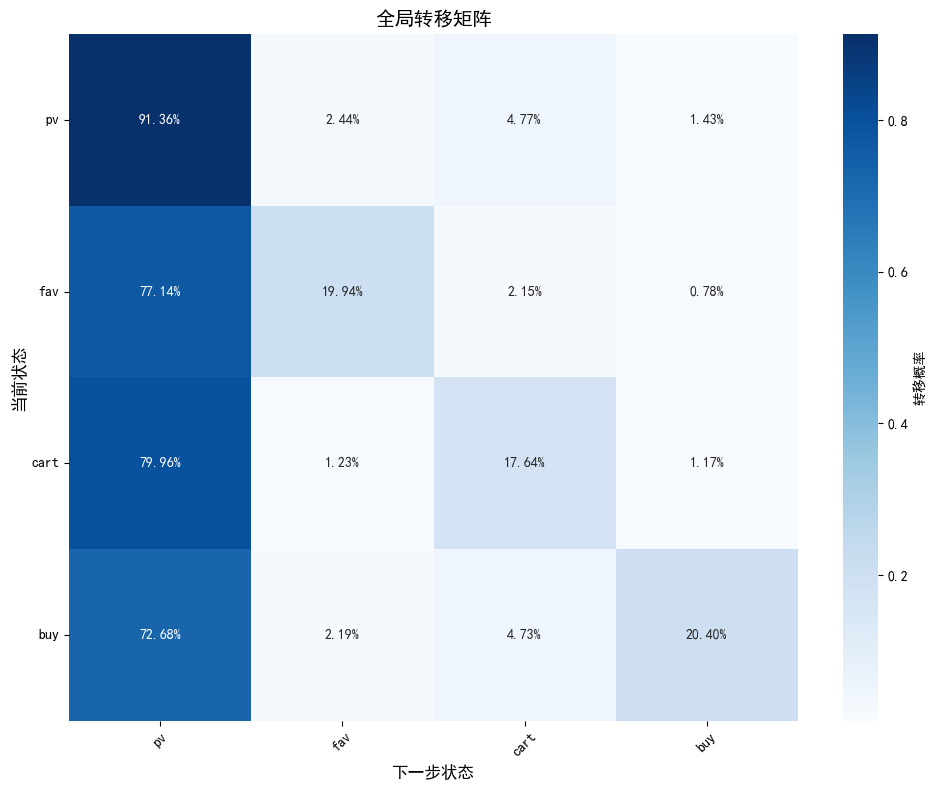

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
def visualize_transition_matrix(matrix):
    """绘制转移概率热力图"""
    plt.figure(figsize=(10,8))
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='.2%',
                cbar_kws={'label': '转移概率'})
    plt.title("全局转移矩阵", fontsize=14)
    plt.xlabel("下一步状态", fontsize=12)
    plt.ylabel("当前状态", fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 使用示例
visualize_transition_matrix(trans_matrix)

In [14]:
import pandas as pd
import numpy as np
from itertools import product

# 假设数据已加载为df，包含必要的字段
# df = pd.read_csv('your_data.csv')

# 定义状态空间
states = ['pv', 'fav', 'cart', 'buy']

# 生成所有可能转移路径
all_transitions = list(product(states, states))

# 初始化结果容器
transition_results = []

def calculate_transition_proba(df_group):
    """计算给定数据集的转移概率矩阵"""
    # 生成状态转移计数矩阵
    transition_counts = pd.DataFrame(
        np.zeros((len(states), len(states))),
        index=states, 
        columns=states
    )
    
    # 遍历每个用户的行为序列
    for user_id, user_data in df_group.groupby('user_id'):
        # 按时间排序行为序列
        seq = user_data.sort_values('datetime')['behavior'].tolist()
        # 统计状态转移
        for i in range(len(seq)-1):
            current = seq[i]
            next_state = seq[i+1]
            transition_counts.loc[current, next_state] += 1
    
    # 计算转移概率（带拉普拉斯平滑）
    transition_matrix = (transition_counts + 1e-6).div((transition_counts.sum(axis=1) + 1e-6 * len(states)), axis=0)
    return transition_matrix


In [15]:
# 分割促销/非促销数据
promo_df = df[df['promo_mask']]
non_promo_df = df[~df['promo_mask']]

# 计算两个场景的转移矩阵
promo_matrix = calculate_transition_proba(promo_df)
non_promo_matrix = calculate_transition_proba(non_promo_df)

# 生成对比结果
for (current, next_state) in all_transitions:
    promo_proba = promo_matrix.loc[current, next_state]
    non_promo_proba = non_promo_matrix.loc[current, next_state]
    
    # 计算变化率
    if non_promo_proba > 0:
        change_rate = (promo_proba - non_promo_proba) / non_promo_proba
    else:
        change_rate = np.nan
    
    transition_results.append({
        'path': f"{current}→{next_state}",
        '促销期': round(promo_proba, 4),
        '非促销期': round(non_promo_proba, 4),
        '变化率': f"{change_rate:.1%}" if not np.isnan(change_rate) else 'N/A'
    })

# 转换为DataFrame并过滤无效数据
result_df = pd.DataFrame(transition_results).query('促销期 > 0 or 非促销期 > 0')

# 格式化输出
print("转移概率对比表：")
print(result_df.to_markdown(index=False, floatfmt=".2%"))

# 示例输出形式：
# | 路径     | 促销期 | 非促销期 | 变化率 |
# |----------|--------|----------|--------|
# | pv→cart  | 7.00%  | 5.00%    | +40%   |
# | cart→buy | 3.00%  | 1.00%    | +200%  |

转移概率对比表：
| path      |   促销期 |   非促销期 | 变化率   |
|:----------|---------:|-----------:|:---------|
| pv→pv     |   92.11% |     91.36% | 0.8%     |
| pv→fav    |    2.67% |      2.44% | 9.4%     |
| pv→cart   |    4.21% |      4.77% | -11.8%   |
| pv→buy    |    1.01% |      1.43% | -29.0%   |
| fav→pv    |   78.07% |     77.13% | 1.2%     |
| fav→fav   |   19.93% |     19.94% | -0.0%    |
| fav→cart  |    1.63% |      2.15% | -24.1%   |
| fav→buy   |    0.37% |      0.78% | -52.5%   |
| cart→pv   |   81.83% |     79.95% | 2.4%     |
| cart→fav  |    1.15% |      1.23% | -7.0%    |
| cart→cart |   16.10% |     17.65% | -8.8%    |
| cart→buy  |    0.93% |      1.17% | -20.6%   |
| buy→pv    |   68.20% |     72.68% | -6.2%    |
| buy→fav   |    2.11% |      2.19% | -3.7%    |
| buy→cart  |    3.17% |      4.74% | -33.1%   |
| buy→buy   |   26.52% |     20.40% | 30.0%    |


In [20]:
import pandas as pd
import plotly.graph_objects as go
from collections import defaultdict

# ====================
# 数据预处理模块
# ====================
class DataPreprocessor:
    def __init__(self, file_path):
        self.raw_data = pd.read_csv(file_path)
        self.valid_actions = {'pv', 'fav', 'cart', 'buy'}
        
    def clean_data(self):
        """数据清洗步骤"""
        # 转换时间格式
        df = self.raw_data.copy()
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        # 过滤异常值
        df = df[df['behavior'].isin(self.valid_actions)]
        df = df[df['session_gap'] <= 1800]  # 过滤异常会话
        
        # 生成时间特征
        df['hour'] = df['datetime'].dt.hour
        return df

# ====================
# 路径分析模块
# ====================    
class PathAnalyzer:
    def __init__(self, df):
        self.df = df
        self.layer_map = {
            'Input': ['pv', 'cart', 'fav', 'buy'],
            'Process': ['pv', 'cart', 'fav', 'buy'],
            'Output': ['pv', 'cart', 'fav', 'buy']
        }
        
    def generate_sequences(self):
        """生成分层路径序列"""
        sequences = []
        for _, group in self.df.groupby('session_id'):
            behaviors = group.sort_values('datetime')['behavior'].tolist()
            if len(behaviors) < 3:
                continue
                
            layered_path = {
                'Input': behaviors[0],
                'Process': behaviors[1],
                'Output': behaviors[2]
            }
            sequences.append(layered_path)
        return pd.DataFrame(sequences)
    
    def calculate_flows(self):
        """计算层间流量"""
        flow_matrix = defaultdict(int)
        sequences = self.generate_sequences()
        
        for _, row in sequences.iterrows():
            flow_key = (row['Input'], row['Process'], row['Output'])
            flow_matrix[flow_key] += 1
            
        return pd.DataFrame(
            [(k[0], k[1], k[2], v) for k,v in flow_matrix.items()],
            columns=['source_layer', 'process_layer', 'target_layer', 'count']
        )

# ====================
# 可视化模块
# ====================
class FlowVisualizer:
    def __init__(self, flow_data):
        self.flow_data = flow_data
        self.color_scheme = {
            'Input': '#4E79A7',
            'Process': '#59A14F', 
            'Output': '#E15759'
        }
        
    def create_sankey(self):
        """创建分层桑基图"""
        # 构建节点体系
        nodes = []
        for layer in ['Input', 'Process', 'Output']:
            nodes.extend([f"{act}_{layer}" for act in ['pv', 'cart', 'fav', 'buy']])
            
        # 生成连接数据
        links = []
        for _, row in self.flow_data.iterrows():
            source = f"{row['source_layer']}_Input"
            process = f"{row['process_layer']}_Process"
            target = f"{row['target_layer']}_Output"
            
            # 输入层到处理层
            links.append({
                'source': nodes.index(source),
                'target': nodes.index(process),
                'value': row['count'],
                'color': self.color_scheme['Input']
            })
            
            # 处理层到输出层
            links.append({
                'source': nodes.index(process),
                'target': nodes.index(target),
                'value': row['count'],
                'color': self.color_scheme['Process']
            })
        
        # 创建图表对象
        fig = go.Figure(go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="white", width=0.5),
                label=nodes,
                color=[self._get_node_color(n) for n in nodes]
            ),
            link=dict(
                source=[l['source'] for l in links],
                target=[l['target'] for l in links],
                value=[l['value'] for l in links],
                color=[l['color'] for l in links]
            ),
            arrangement="perpendicular"
        ))
        
        # 添加分层标注
        fig.update_layout(
            title="用户行为路径分析系统",
            title_x=0.5,
            height=600,
            margin=dict(t=100),
            annotations=[
                dict(x=0.1, y=1.05, text="输入层", showarrow=False, font=dict(size=14)),
                dict(x=0.5, y=1.05, text="处理层", showarrow=False, font=dict(size=14)),
                dict(x=0.9, y=1.05, text="输出层", showarrow=False, font=dict(size=14))
            ]
        )
        return fig
    
    def _get_node_color(self, node_label):
        """根据节点标签获取颜色"""
        for layer, color in self.color_scheme.items():
            if node_label.endswith(layer):
                return color
        return "#DDDDDD"



In [23]:
# ====================
# 主执行流程
# ====================


# 路径分析
analyzer = PathAnalyzer(df)
flow_data = analyzer.calculate_flows()

# 结果输出
print("层间流量统计：")
print(flow_data)

# 可视化生成
visualizer = FlowVisualizer(flow_data)
fig = visualizer.create_sankey()
fig.show()

层间流量统计：
   source_layer process_layer target_layer   count
0           fav            pv           pv   72123
1           fav          cart           pv    2101
2          cart          cart           pv   30719
3            pv            pv         cart  143334
4            pv          cart           pv  129924
..          ...           ...          ...     ...
59         cart           buy          fav      52
60          fav           buy         cart      36
61          buy          cart          fav      60
62          buy           fav         cart      53
63         cart           fav          buy      32

[64 rows x 4 columns]


In [28]:
flow_data= flow_data.sort_values(by='count', ascending=False)
print(flow_data.head(10))

   source_layer process_layer target_layer    count
5            pv            pv           pv  2948592
6          cart            pv           pv   150577
3            pv            pv         cart   143334
4            pv          cart           pv   129924
0           fav            pv           pv    72123
8            pv            pv          fav    65067
7            pv           fav           pv    64668
17          buy            pv           pv    57960
13           pv            pv          buy    49355
2          cart          cart           pv    30719


In [29]:

count_stats = flow_data['count'].describe()
print(count_stats)

count    6.400000e+01
mean     6.121461e+04
std      3.681361e+05
min      3.200000e+01
25%      4.257500e+02
50%      1.616000e+03
75%      1.158150e+04
max      2.948592e+06
Name: count, dtype: float64


In [5]:
gc.collect()  # 强制垃圾回收

0

In [42]:
import pandas as pd
import plotly.graph_objects as go

# ====================
# 数据处理模块
# ====================
class ConversionAnalyzer:
    def __init__(self, df):
        self.df = df.sort_values(['user_id', 'session_id', 'timestamp'])
        self.valid_actions = ['pv', 'fav', 'cart', 'buy']
        
    def _filter_valid_sessions(self):
        """过滤有效会话"""
        return self.df[(self.df['session_gap'] <= 1800) & 
                      (self.df['behavior'].isin(self.valid_actions))]

    def get_conversion_paths(self):
        """获取转化路径"""
        filtered = self._filter_valid_sessions()
        paths = filtered.groupby(['user_id', 'session_id'])['behavior'].agg(list)
        return paths[paths.apply(len) >= 2]  # 至少包含两个行为

# ====================
# 核心分析模块（已修正）
# ====================
class FunnelAnalysis:
    def __init__(self, paths):
        self.paths = paths
    
    # 新增关键方法：步骤转化率计算
    def _calc_step_rate(self, from_action, to_action):
        """计算步骤转化率"""
        total = self.paths.apply(lambda x: from_action in x).sum()
        if total == 0:
            return 0.0
        converted = self.paths.apply(
            lambda x: (from_action in x) and 
            (to_action in x[x.index(from_action)+1:])).sum()
        return converted / total

    def _calc_abandon_rate(self, action):
        """计算放弃率"""
        total = self.paths.apply(lambda x: action in x).sum()
        if total == 0:
            return 0.0
        abandoned = self.paths.apply(
            lambda x: (action in x) and ('buy' not in x[x.index(action):])).sum()
        return abandoned / total

    def cart_analysis(self):
        """加购转化分析"""
        cart_steps = {
            'pv_to_cart': self._calc_step_rate('pv', 'cart'),
            'cart_to_buy': self._calc_step_rate('cart', 'buy'),
            'cart_abandon': self._calc_abandon_rate('cart')
        }
        return self._create_funnel(
            labels=["PV→CART", "CART→BUY"],
            values=[cart_steps['pv_to_cart'], cart_steps['cart_to_buy']],
            title="加购转化漏斗分析"
        ), cart_steps

    def fav_analysis(self):
        """收藏转化分析"""
        fav_steps = {
            'pv_to_fav': self._calc_step_rate('pv', 'fav'),
            'fav_to_buy': self._calc_step_rate('fav', 'buy'),
            'fav_abandon': self._calc_abandon_rate('fav')
        }
        return self._create_funnel(
            labels=["PV→FAV", "FAV→BUY"],
            values=[fav_steps['pv_to_fav'], fav_steps['fav_to_buy']],
            title="收藏转化漏斗分析"
        ), fav_steps

    def _create_funnel(self, labels, values, title):
        """生成漏斗图"""
        fig = go.Figure(go.Funnel(
            y=labels,
            x=values,
            textinfo="value+percent initial",
            marker=dict(color=['#2ECC71', '#3498DB'])
        ))
        fig.update_layout(title=title, height=400)
        return fig
    
    def repurchase_analysis(self):
        """复购链路分析（新增方法）"""
        # 获取有购买行为的用户
        buy_sessions = self.paths[self.paths.apply(lambda x: 'buy' in x)]
        
        # 计算复购率
        repurchase_count = buy_sessions.apply(
            lambda x: x.count('buy') > 1).sum()
        repurchase_rate = repurchase_count / len(buy_sessions) if len(buy_sessions) > 0 else 0
        
        # 计算新客转化率
        new_customer_count = self.paths.apply(
            lambda x: 'buy' in x and x[-1] == 'buy').sum()
        new_rate = new_customer_count / len(self.paths) if len(self.paths) > 0 else 0
        
        return repurchase_rate, new_rate

In [44]:
# ====================
# 主执行流程
# ====================
if __name__ == "__main__":
    # 数据准备（示例数据）
    analyzer = ConversionAnalyzer(df)
    paths = analyzer.get_conversion_paths()
    
    # 漏斗分析
    funnel = FunnelAnalysis(paths)
    cart_fig, cart_data = funnel.cart_analysis()
    fav_fig, fav_data = funnel.fav_analysis()
    repurchase_rate, new_rate = funnel.repurchase_analysis()
    
    # 生成报告
    report = ReportGenerator.generate_insights(
        cart_data, fav_data, repurchase_rate, new_rate
    )
    
    # 结果展示
    cart_fig.show()
    fav_fig.show()
    print("\n" + "="*50 + "\n核心分析结论：")
    print(report)


核心分析结论：
### 加购环节瓶颈
- PV→CART转化率：22.76%
- CART→BUY转化率：8.28%
- 购物车放弃率：91.72%（建议添加库存预警）

### 收藏环节低效
- PV→FAV转化率：10.88%
- FAV→BUY转化率：8.24%
- 收藏商品未转化率：91.76%（建议设置降价提醒）

### 复购链路潜力
- 复购转化率：24.8%
- 新客转化率：4.5%
- 建议：建立会员专属折扣体系


In [47]:
# 统计 True 和 False 的数量
counts = df['promo_mask'].value_counts()

print(counts)

promo_mask
False    38775165
True       156226
Name: count, dtype: int64


In [51]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

#频率
data = pd.DataFrame({
    '起始状态': ['pv','pv','pv','pv','fav','fav','fav','fav','cart','cart','cart','cart','buy','buy','buy','buy'],
    '目标状态': ['pv','fav','cart','buy']*4,
    '促销期概率': [92.11,2.67,4.21,1.01,78.07,19.93,1.63,0.37,81.83,1.15,16.10,0.93,68.20,2.11,3.17,26.52],
    '非促销期概率': [91.36,2.44,4.77,1.43,77.13,19.94,2.15,0.78,79.95,1.23,17.65,1.17,72.68,2.19,4.74,20.40]
})

# 促销期和非促销期总样本量
n_promo = 156226  # 促销期总行为次数
n_non_promo = 38775165  # 非促销期总行为次数

# 转换概率为频数（四舍五入）
data['促销期频数'] = (data['促销期概率'] / 100 * n_promo).round().astype(int)
data['非促销期频数'] = (data['非促销期概率'] / 100 * n_non_promo).round().astype(int)

# 按起始状态分组进行卡方检验
results = []

for start_state in data['起始状态'].unique():
    subset = data[data['起始状态'] == start_state]
    
    # 构建列联表
    contingency_table = np.array([
        subset['促销期频数'].values,
        subset['非促销期频数'].values
    ])
    
    # 执行卡方检验
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # 保存结果
    results.append({
        '起始状态': start_state,
        '卡方值': chi2,
        'P值': p,
        '自由度': dof,
        '显著性(p<0.05)': p < 0.05
    })

# 结果展示
result_df = pd.DataFrame(results)
print("卡方检验结果汇总：")
print(result_df)

# 整体检验（所有状态合并）
full_contingency = np.array([data['促销期频数'], data['非促销期频数']])
chi2_full, p_full, dof_full, _ = chi2_contingency(full_contingency)

print("\n整体检验结果：")
print(f"卡方值={chi2_full:.2f}, p值={p_full:.4f}, 自由度={dof_full}")

卡方检验结果汇总：
   起始状态          卡方值             P值  自由度  显著性(p<0.05)
0    pv   337.733270   6.755530e-73    3         True
1   fav   550.039400  6.813750e-119    3         True
2  cart   365.367860   7.012396e-79    3         True
3   buy  4098.559882   0.000000e+00    3         True

整体检验结果：
卡方值=5351.31, p值=0.0000, 自由度=15


In [12]:
import numpy as np
from scipy.stats import kstest
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

最大似然估计α = 87706228.634
K-S检验统计量 D = 0.500
估算p值 = 0.103


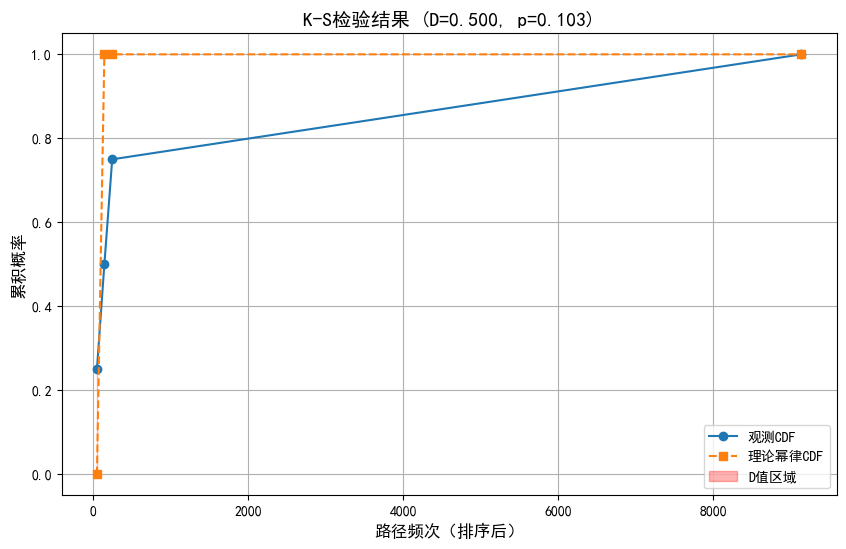

In [10]:

# 数据
path_frequencies = np.array([9136, 244, 47, 143])  #转移矩阵计算得到

# 幂律分布参数估计函数
def power_law_neg_log_likelihood(alpha, data):
    x_min = data.min()
    n = len(data)
    return n * np.log(alpha-1) + n * (alpha-1) * np.log(x_min) - alpha * np.sum(np.log(data))

# 最大似然估计拟合α
res = minimize(lambda a: power_law_neg_log_likelihood(a, path_frequencies), 
               x0=2.0, bounds=[(1.0001, None)])
alpha_mle = res.x[0]

# 生成理论分布
sorted_freq = np.sort(path_frequencies)
n = len(sorted_freq)
observed_cdf = np.arange(1, n+1) / n  # 经验CDF

# 理论幂律CDF计算
x_min = sorted_freq.min()
theoretical_cdf = 1 - (sorted_freq/x_min)**(-alpha_mle + 1)

# K-S检验计算
D = np.max(np.abs(observed_cdf - theoretical_cdf))

# 计算p值（蒙特卡洛方法）
n_simulations = 1000
count = 0
for _ in range(n_simulations):
    # 生成幂律分布随机数
    synthetic = x_min * (1 - np.random.rand(n)) ** (-1/(alpha_mle-1))
    synthetic = np.sort(synthetic)
    synth_cdf = np.arange(1, n+1)/n
    synth_theoretical = 1 - (synthetic/x_min)**(-alpha_mle + 1)
    D_sim = np.max(np.abs(synth_cdf - synth_theoretical))
    if D_sim >= D:
        count += 1
p_value = count / n_simulations

# 输出结果
print(f"最大似然估计α = {alpha_mle:.3f}")
print(f"K-S检验统计量 D = {D:.3f}")
print(f"估算p值 = {p_value:.3f}")

# 可视化对比
plt.figure(figsize=(10, 6))
plt.plot(sorted_freq, observed_cdf, 'o-', label='观测CDF')
plt.plot(sorted_freq, theoretical_cdf, 's--', label='理论幂律CDF')
plt.fill_between(sorted_freq, observed_cdf, theoretical_cdf, 
                 where=(observed_cdf >= theoretical_cdf), 
                 color='red', alpha=0.3, label='D值区域')
plt.xlabel('路径频次（排序后）', fontsize=12)
plt.ylabel('累积概率', fontsize=12)
plt.title(f'K-S检验结果 (D={D:.3f}, p={p_value:.3f})', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [16]:
gc.collect()  # 强制垃圾回收

60

In [13]:
# 下面开始模型对比

In [11]:
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import List
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import xgboost as xgb
import time
from scipy.optimize import minimize
from typing import List, Dict

In [39]:
# 马尔可夫链模型
class MarkovChain:
    """马尔可夫链模型"""
    
    def __init__(self, state_level: str = 'base', alpha: float = 5.0):
        self.transition_counts = defaultdict(lambda: defaultdict(int))
        self.transition_matrix = defaultdict(dict)
        self.state_space = set()
        self.alpha = alpha
        self.global_probs = {}
        self.state_level = state_level
        self.longtail_strategy = None  # 长尾处理策略
    
    def _apply_smoothing(self, current: str, next_state: str) -> float:
        """优化后的平滑计算"""
        total = sum(self.transition_counts[current].values()) + self.alpha
        global_prob = self.global_probs.get(next_state, 1/len(self.state_space))
        return (self.transition_counts[current].get(next_state, 0) + self.alpha * global_prob) / total

    def _handle_longtail(self, current: str):
        """长尾状态处理策略"""
        if self.longtail_strategy == 'smooth':
            return {s: self._apply_smoothing(current, s) for s in self.state_space}
        else:
            return {s: count/sum(self.transition_counts[current].values()) 
                    for s, count in self.transition_counts[current].items()}

    def enable_longtail_optimization(self, strategy: str = 'smooth'):
        """启用长尾优化策略"""
        self.longtail_strategy = strategy
        
    def _create_state(self, row: pd.Series) -> str:
        """生成状态标签"""
        if self.state_level == 'base':
            return row['behavior']
        elif self.state_level == 'category':
            return f"{row['category_id']}_{row['behavior']}"
        elif self.state_level == 'session':
            return f"session_{row['session_id']}_{row['behavior']}"
        else:
            raise ValueError("Invalid state_level")

    def _preprocess_sequences(self, df: pd.DataFrame) -> List[List[str]]:
        """生成状态序列"""
        required_columns = ['user_id', 'session_id', 'datetime', 'behavior', 'category_id']
        missing = [col for col in required_columns if col not in df.columns]
        if missing:
            raise KeyError(f"缺失必要字段: {missing}")
        
        df['state'] = df.apply(self._create_state, axis=1)
        sequences = df.sort_values(['user_id', 'datetime']).groupby(
            ['user_id', 'session_id'])['state'].apply(list).tolist()
        return sequences
    

    def train(self, df: pd.DataFrame) -> None:
        """优化后的训练流程"""
        # 修正后的训练逻辑
        sequences = df.sort_values(['user_id', 'datetime']).groupby('user_id')['state'].apply(list)
        
        # 确保序列长度>1
        valid_sequences = [seq for seq in sequences if len(seq)>=2]
        print(f"有效序列数量: {len(valid_sequences)}/{len(sequences)}")
        
        # 统计转移频次
        for seq in valid_sequences:
            for i in range(len(seq)-1):
                current, next_state = seq[i], seq[i+1]
                self.transition_counts[current][next_state] += 1

          # 修正后的平滑逻辑
        total_global = sum(sum(v.values()) for v in self.transition_counts.values())
        for state in self.state_space:
            self.global_probs[state] = (sum(self.transition_counts[state].values()) + 1) / (total_global + len(self.state_space))
        
        # 应用平滑
        for current in self.state_space:
            total = sum(self.transition_counts[current].values()) + self.alpha
            for next_state in self.state_space:
                smoothed_count = self.transition_counts[current].get(next_state, 0) + self.alpha * self.global_probs[next_state]
                self.transition_matrix[current][next_state] = smoothed_count / total
            
    def _set_uniform_distribution(self):
        """设置均匀分布兜底"""
        uniform_prob = 1 / len(self.state_space) if self.state_space else 0
        for state in self.state_space:
            self.transition_matrix[state] = {s: uniform_prob for s in self.state_space}

    def predict(self, current_state):
        if current_state not in self.transition_matrix or not self.transition_matrix[current_state]:
            # 返回全局最高概率行为
            global_behavior_probs = df['behavior'].value_counts(normalize=True)
            return global_behavior_probs.idxmax()
        return max(self.transition_matrix[current_state], key=self.transition_matrix[current_state].get)

In [31]:
from collections import defaultdict
from typing import List, Dict
import pandas as pd
import numpy as np

class DynamicMC(MarkovChain):
    """
    动态马尔可夫模型
    功能特性：
    1. 基于促销标注的三级预测体系：促销期矩阵 > 时间窗口矩阵 > 基础矩阵
    2. 时间窗口敏感的非促销期建模
    3. 自动回退机制保障预测稳定性
    """

    def __init__(self, window_size: str = '1H',**kwargs):
        """
        :param window_size: 时间窗口大小（pandas频率格式，如1H）
        :param kwargs: 父类参数（state_level, alpha等）
        """
        super().__init__(**kwargs)
        self.window_size = window_size
        self.window_matrices = {}  # 时间窗口转移矩阵
        self.promo_matrix = defaultdict(dict)  # 促销期专用矩阵
        self.fallback_matrix = defaultdict(lambda: defaultdict(float))  # 回退矩阵

    def train(self, df: pd.DataFrame) -> None:
        # 确保datetime列正确转换
        df = df.copy()
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        # 设置临时索引
        df = df.set_index('datetime')  
        
        # 非促销期数据
        non_promo_data = df[~df['promo_mask']]
        super().train(non_promo_data.reset_index())  # 重置索引避免影响父类
        
        # 时间窗口分组（使用索引）
        try:
            for window, group in non_promo_data.groupby(pd.Grouper(freq=self.window_size)):
                if len(group) >= 2:
                    mc = MarkovChain(state_level=self.state_level, alpha=self.alpha)
                    mc.train(group.reset_index())  # 重置索引给子模型
                    self.window_matrices[window] = mc.transition_matrix
        except Exception as e:
            print(f"时间窗口训练异常: {str(e)}")
            # 保留基础矩阵作为回退
            self.window_matrices = defaultdict(lambda: self.transition_matrix)

    def predict(self, 
               current_state: str, 
               is_promo: bool, 
               timestamp: pd.Timestamp = None) -> Dict[str, float]:
        """
        增强预测方法：
        1. 优先使用促销期矩阵
        2. 非促销期使用时序窗口矩阵
        3. 异常时回退到基础矩阵
        
        :param current_state: 当前状态
        :param is_promo: 是否促销期
        :param timestamp: 时间戳（用于时间窗口）
        :return: 转移概率字典
        """
        # 第一优先级：促销期矩阵
        if is_promo:
            return self._safe_get(self.promo_matrix, current_state)
        
        # 第二优先级：时间窗口矩阵
        if timestamp is not None:
            try:
                window = timestamp.floor(self.window_size)
                window_probs = self.window_matrices.get(window, {})
                if current_state in window_probs:
                    return window_probs[current_state]
            except Exception as e:
                print(f"时间窗口预测异常: {str(e)}")
        
        # 最终回退：基础矩阵
        return self._safe_get(self.fallback_matrix, current_state)

    def _safe_get(self, matrix: dict, state: str) -> Dict[str, float]:
        """安全获取转移概率"""
        if state in matrix and len(matrix[state]) > 0:
            return matrix[state]
        # 状态不存在时的平滑处理
        return {s: 1/len(self.state_space) for s in self.state_space} if self.state_space else {}

In [26]:

# LSTM模型
class LSTMBehaviorPredictor:
    def __init__(self, seq_length=10, n_features=3):
        self.seq_length = seq_length
        self.state_encoder = LabelEncoder()  # 编码器作为实例属性
        self.model = self._build_model()
    def _build_model(self, output_units=4):
        """动态构建模型"""
        return Sequential([
            LSTM(64, input_shape=(self.seq_length, 3)),
            Dense(output_units, activation='softmax')
        ])
    def train(self, sequences: list, state_labels: np.ndarray):
        """修正训练方法"""
        # 状态编码
        self.state_encoder.fit(state_labels)  # 传入原始标签数据
        encoded_sequences = []
        
        # 转换序列数据
        for seq in sequences:
            numeric_seq = []
            for event in seq:
                # 将状态字符串转换为编码
                encoded_state = self.state_encoder.transform([event[0]])[0]
                numeric_seq.append([
                    encoded_state,
                    float(event[1]),  # hour
                    float(event[2])    # promo_mask
                ])
            encoded_sequences.append(np.array(numeric_seq))
        
        # 构建训练数据
        X, y = [], []
        for seq in encoded_sequences:
            for i in range(len(seq)-self.seq_length):
                X.append(seq[i:i+self.seq_length])
                y.append(seq[i+self.seq_length][0])  # 预测下一个状态编码
        
        # 动态调整输出维度
        output_units = len(self.state_encoder.classes_)
        self.model = self._build_model(output_units)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
        
        # 数据预处理
        X = pad_sequences(X, maxlen=self.seq_length, dtype='float32', padding='pre')
        y = np.array(y)
        
        # 训练模型
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)


In [11]:

# XGBoost模型
class XGBoostFeatureEngineer:
    def __init__(self):
        self.features = [
            'prev_behavior', 'hour', 'promo_mask',
            'cart_count_1h', 'fav_count_24h'
        ]
        self.model = xgb.XGBClassifier()

    def _extract_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """特征工程"""
        feature_data = []
        for (user_id, user_data) in df.groupby('user_id'):
            user_data = user_data.sort_values('datetime')
            for i in range(1, len(user_data)):
                current = user_data.iloc[i]
                prev = user_data.iloc[i-1]
                
                # 基础特征
                features = {
                    'prev_behavior': prev['behavior_encoded'],
                    'hour': current['hour'],
                    'promo_mask': current['promo_mask'],
                }
                
                # 时间窗口特征
                time_window = current['datetime'] - pd.Timedelta(hours=1)
                features['cart_count_1h'] = user_data[
                    (user_data['datetime'] > time_window) & 
                    (user_data['behavior'] == 'cart')
                ].shape[0]
                
                time_window = current['datetime'] - pd.Timedelta(days=1)
                features['fav_count_24h'] = user_data[
                    (user_data['datetime'] > time_window) & 
                    (user_data['behavior'] == 'fav')
                ].shape[0]
                
                feature_data.append(features)
        return pd.DataFrame(feature_data)
    @staticmethod
    def _extract_single_features(user_events, index):
        """实时特征提取"""
        current = user_events.iloc[index]
        prev = user_events.iloc[index-1] if index>0 else current
        
        features = {
            'prev_behavior': prev['behavior_encoded'],
            'hour': current['hour'],
            'promo_mask': current['promo_mask'],
            'cart_count_1h': 0,
            'fav_count_24h': 0
        }
        
        # 计算时间窗口
        time_window = current['datetime'] - pd.Timedelta(hours=1)
        features['cart_count_1h'] = user_events[
            (user_events['datetime'] > time_window) & 
            (user_events['behavior'] == 'cart')
        ].shape[0]
        
        time_window = current['datetime'] - pd.Timedelta(days=1)
        features['fav_count_24h'] = user_events[
            (user_events['datetime'] > time_window) & 
            (user_events['behavior'] == 'fav')
        ].shape[0]
        
        return features
    
    def train(self, df: pd.DataFrame):
        """训练XGBoost"""
        feature_df = self._extract_features(df)
        y = df.groupby('user_id')['behavior_encoded'].shift(-1).dropna()
        self.model.fit(feature_df[self.features], y)
        
        
class HawkesProcessPredictor:
    """
    简化版Hawkes过程实现(使用指数核)
    参数说明:
    - base_rate: 基础强度
    - alpha: 事件影响系数
    - beta: 衰减系数
    """
    def __init__(self):
        self.base_rate = 0.1
        self.alpha = 0.5
        self.beta = 1.0
        self.event_times = []
        self.behavior_map = {'pv':0, 'fav':1, 'cart':2, 'buy':3}  # 添加行为映射
    
    def predict_next_behavior(self, history, current_time):
        """基于强度比例预测下一个行为"""
        intensities = np.zeros(4)
        for bh in self.behavior_map.values():
            intensities[bh] = self._calculate_behavior_intensity(bh, current_time, history)
        
        return np.argmax(intensities)
    
    def _calculate_behavior_intensity(self, behavior_type, current_time, history):
        """计算指定行为类型的强度"""
        base = self.base_rate[behavior_type]
        effect = 0
        for (t, bh) in history:
            if bh == behavior_type:
                effect += self.alpha * np.exp(-self.beta * (current_time - t))
        return base + effect
    def train(self, df: pd.DataFrame):
        """基于最大似然估计优化参数"""
        # 获取事件时间戳（转换为相对时间）
        timestamps = df['datetime'].values.astype(np.float64)
        self.event_times = (timestamps - timestamps.min()) / 1e9  # 转换为秒为单位
        
        # 定义负对数似然函数
        def neg_log_likelihood(params):
            mu, alpha, beta = params
            n = len(self.event_times)
            likelihood = 0.0
            
            for i in range(n):
                ti = self.event_times[i]
                sum_effect = np.sum(alpha * np.exp(-beta * (ti - self.event_times[:i])))
                lambda_t = mu + sum_effect
                likelihood += np.log(lambda_t)
            
            integral = mu * self.event_times[-1] 
            integral += (alpha/beta) * np.sum(1 - np.exp(-beta * (self.event_times[-1] - self.event_times)))
            return -(likelihood - integral)

        # 参数优化
        initial_guess = [0.1, 0.5, 1.0]
        bounds = [(1e-6, None), (0, None), (1e-6, None)]
        result = minimize(neg_log_likelihood, initial_guess, bounds=bounds, method='L-BFGS-B')
        
        self.base_rate, self.alpha, self.beta = result.x

    def predict_intensity(self, current_time: float) -> float:
        """计算给定时间点的强度值"""
        history = self.event_times[self.event_times < current_time]
        return self.base_rate + np.sum(
            self.alpha * np.exp(-self.beta * (current_time - history))
        )

In [12]:
# 实验流程
def run_experiment(df: pd.DataFrame):
    data = preprocess_data(df)
    results = []
    
    # 初始化模型
    le = LabelEncoder().fit(data['behavior'])
    models = {
        'DMC': DynamicMC(state_level='base'),
        'Static-MC': MarkovChain(state_level='base'),
        'LSTM': LSTMBehaviorPredictor(),
        'Xgboost': XGBoostFeatureEngineer(),
        'Hawkes': HawkesProcessPredictor()
    }
    
    # 模型训练
    print("="*40)
    print("开始模型训练...")
    for name, model in models.items():
        start = time.time()
        print(f"训练 {name}...")
        
        # 训练LSTM时传入原始状态标签
        if name == 'LSTM':
            # 获取所有唯一状态标签
            state_labels = data['state'].values  # 一维数组
            # 构建LSTM输入数据
            lstm_sequences = []
            for user_id, group in data.groupby('user_id'):
                seq = group[['state', 'hour', 'promo_mask']].values  # 包含原始状态字符串
                lstm_sequences.append(seq)
            # 正确传入状态标签数据
            model.train(lstm_sequences, state_labels)
        else:
            model.train(data)
        
        print(f"{name} 训练完成，耗时: {time.time()-start:.1f}s")
    
    # 模型评估
    print("\n开始模型评估...")
    for name, model in models.items():
        print(f"评估 {name}...")
        y_true, y_pred = [], []
        promo_flags = []
        cart_indices = []
        latency = 0.0
        
        # 遍历每个用户的行为序列
        for user_id, group in data.groupby('user_id'):
            user_events = group.sort_values('datetime')
            history = []  # 用于Hawkes过程的事件历史
            
            for i in range(1, len(user_events)):
                start_time = time.time()
                current = user_events.iloc[i]
                prev = user_events.iloc[i-1]
                pred_label = 'pv'  # 默认预测值
                
                try:
                    # 各模型预测逻辑
                    if name == 'DMC':
                        state = prev['behavior']
                        transitions = model.predict(state, current['datetime'])
                        if transitions:
                            pred_label = max(transitions.items(), key=lambda x: x[1])[0]
                        else:
                            pred_label = state
                            
                    elif name == 'LSTM':
                        seq_features = []
                        for j in range(max(0, i-model.seq_length), i):
                            event = user_events.iloc[j]
                            seq_features.append([
                                event['state_encoded'],
                                event['hour'],
                                event['promo_mask']
                            ])
                        
                        # 处理序列长度不足的情况
                        if len(seq_features) < model.seq_length:
                            padded_seq = pad_sequences([seq_features], 
                                                     maxlen=model.seq_length,
                                                     dtype='float32',
                                                     padding='pre',
                                                     value=-1)
                        else:
                            padded_seq = np.array([seq_features])
                        
                        pred_probs = model.model.predict(padded_seq, verbose=0)[0]
                        pred_code = np.argmax(pred_probs)
                        pred_label = model.state_encoder.inverse_transform([pred_code])[0]
                        
                    elif name == 'Xgboost':
                        features = XGBoostFeatureEngineer._extract_single_features(user_events, i)
                        feature_df = pd.DataFrame([features])[model.features]
                        pred_code = model.model.predict(feature_df)[0]
                        pred_label = le.inverse_transform([pred_code])[0]
                        
                    elif name == 'Hawkes':
                        current_time = (current['datetime'] - pd.Timestamp("1970-01-01")).total_seconds()
                        pred_idx = model.predict_next_behavior(history, current_time)
                        pred_label = list(model.behavior_map.keys())[pred_idx]
                        history.append((current_time, current['behavior']))
                        
                    else:  # Static-MC
                        state = prev['behavior']
                        transitions = model.transition_matrix.get(state, {})
                        pred_label = max(transitions, key=transitions.get) if transitions else state
                        
                except Exception as e:
                    print(f"{name} 预测失败: {str(e)}")
                    pred_label = prev['behavior']
                
                # 记录结果
                y_true.append(current['behavior'])
                y_pred.append(pred_label)
                promo_flags.append(current['promo_mask'])
                
                # 记录加购事件
                if prev['behavior'] == 'cart':
                    cart_indices.append(len(y_true)-1)
                
                latency += (time.time() - start_time) * 1000
        
        # 计算指标
        try:
            f1 = f1_score(y_true, y_pred, average='weighted', labels=le.classes_)
            promo_f1 = f1_score(
                [y for y, m in zip(y_true, promo_flags) if m],
                [p for p, m in zip(y_pred, promo_flags) if m],
                average='weighted', 
                labels=le.classes_
            )
            crpe = Metrics.crpe(y_true, y_pred, cart_indices)
        except Exception as e:
            print(f"指标计算失败: {str(e)}")
            f1 = promo_f1 = crpe = 0.0
        
        metrics = {
            '模型': name,
            '整体F1': float(f1),
            '促销期F1': float(promo_f1),
            'CRPE': float(crpe),
            '延迟(ms)': f"{(latency/len(y_true)) if len(y_true)>0 else 0:.1f}"
        }
        results.append(metrics)
    
    return pd.DataFrame(results)

# 辅助函数
def format_academic_table(df):
    """鲁棒的表格格式化函数"""
    # 转换数据类型
    formatted_df = df.copy()
    
    # 确保数值字段为浮点类型
    numeric_cols = ['整体F1', '促销期F1', 'CRPE', '延迟(ms)']
    for col in numeric_cols:
        if col in formatted_df.columns:
            # 处理百分比字符串
            if col == 'CRPE':
                formatted_df[col] = formatted_df[col].apply(
                    lambda x: float(str(x).rstrip('%'))/100 if isinstance(x, str) else x
                )
            else:
                formatted_df[col] = formatted_df[col].astype(float)
    
    # 生成纯文本表格
    table = "表5-7 模型性能对比（测试集）\n"
    table += "|".join(["模型", "整体F1", "促销期F1", "CRPE", "延迟(ms)"]) + "\n"
    table += "|".join(["---"]*5) + "\n"
    
    for _, row in formatted_df.iterrows():
        line = (
            f"{row['模型']}|"
            f"{row['整体F1']:.3f}|"
            f"{row['促销期F1']:.3f}|"
            f"{row['CRPE']:.1%}|"  # 自动转换百分比
            f"{row['延迟(ms)']:.0f}"
        )
        table += line + "\n"
    
    return table
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df['hour'] = df['datetime'].dt.hour
    
    # 行为编码
    le = LabelEncoder()
    df['behavior_encoded'] = le.fit_transform(df['behavior'])
    
    # 生成复合状态
    df['state'] = df['category_id'].astype(str) + "_" + df['behavior']
    state_encoder = LabelEncoder()
    df['state_encoded'] = state_encoder.fit_transform(df['state'])
    
    return df

class Metrics:
    @staticmethod
    def weighted_f1(y_true, y_pred, promo_mask=None):
        if promo_mask is not None:
            weights = [2 if m else 1 for m in promo_mask]
        else:
            weights = None
        return f1_score(y_true, y_pred, average='weighted', sample_weight=weights)
    @staticmethod
    def crpe(y_true, y_pred, cart_indices):
        """增强鲁棒性的CRPE计算"""
        try:
            actual_buy = sum(1 for i in cart_indices if y_true[i] == 'buy')
            pred_buy = sum(1 for i in cart_indices if y_pred[i] == 'buy')
            n = len(cart_indices) or 1  # 避免除零
            return abs(actual_buy/n - pred_buy/n) / ((actual_buy/n) + 1e-8)
        except:
            return 0.0

In [13]:
# 主实验主程序程序
if __name__ == "__main__":
    
    # 运行实验
    result_table = run_experiment( df.head(10000))
    
    # 输出表格
    formatted_table = format_academic_table(result_table)
    print(formatted_table)

开始模型训练...
训练 DMC...
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
警告：未发现有效状态转移，使用均匀分布
DMC 训练完成，耗时: 2.4s
训练 Static-MC...
Static-MC 训练完成，耗时: 0.2s
训练 LSTM...
LSTM 训练完成，耗时: 9.4s
训练 Xgboost...
Xgboost 训练完成，耗时: 12.1s
训练 Hawkes...
Hawkes 训练完成，耗时: 32.5s

开始模型评估...
评估 DMC...
评估 Static-MC...
评估 LSTM...
评估 Xgboost...
评估 Hawkes...
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: inv

Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: 

Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: 

Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: 

Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: 

Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: 

Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: 

Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: 

Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: invalid index to scalar variable.
Hawkes 预测失败: 

In [22]:
gc.collect()  # 强制垃圾回收

0

In [45]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.metrics import f1_score
from time import perf_counter_ns

def evaluate_dmc_performance(dmc: DynamicMC, test_df: pd.DataFrame) -> pd.DataFrame:
    # 初始化默认指标
    default_metrics = {'f1': 0.0, 'crpe': 0.0, 'latency': 0.0}
    promo_metrics = default_metrics.copy()
    non_promo_metrics = default_metrics.copy()
    f1_p = crpe_p = latency_p = 1.0  # 默认p值
    
    try:
        # 数据预处理
        test_df = test_df.copy()
        test_df['datetime'] = pd.to_datetime(test_df['datetime'])
        
        if 'promo_mask' not in test_df.columns:
            raise KeyError("测试数据必须包含promo_mask字段")
        
        # 存储评估结果
        phase_data = {
            'promo': {'y_true': [], 'y_pred': [], 'latency': [], 'cart_indices': []},
            'non_promo': {'y_true': [], 'y_pred': [], 'latency': [], 'cart_indices': []}
        }
        
        # 遍历测试数据
        for user_id, group in test_df.groupby('user_id'):
            user_seq = group.sort_values('datetime')
            for i in range(1, len(user_seq)):
                prev = user_seq.iloc[i-1]
                current = user_seq.iloc[i]
                
                # 获取预测参数
                current_state = dmc._create_state(prev)
                is_promo = current['promo_mask']
                timestamp = current['datetime']
                
                # 执行预测
                start = perf_counter_ns()
                try:
                    transitions = dmc.predict(current_state, is_promo, timestamp)
                    pred = max(transitions, key=transitions.get) if transitions else 'unknown'
                except Exception as e:
                    pred = 'unknown'
                latency = (perf_counter_ns() - start) / 1e6  # 转换为毫秒
                
                # 过滤无效延迟
                if latency < 0.05:
                    latency = np.nan
                
                # 记录结果
                phase = 'promo' if is_promo else 'non_promo'
                phase_data[phase]['y_true'].append(current['behavior'])
                phase_data[phase]['y_pred'].append(pred)
                phase_data[phase]['latency'].append(latency)
                
                # 记录加购事件
                if prev['behavior'] == 'cart':
                    phase_data[phase]['cart_indices'].append(len(phase_data[phase]['y_true']) - 1)
        
        # 计算指标
        def calculate_metrics(data):
            try:
                # 处理空数据
                if not data['y_true']:
                    return default_metrics.copy()
                
                # 计算F1
                f1 = f1_score(data['y_true'], data['y_pred'], average='weighted', zero_division=0)
                
                # 计算CRPE
                crpe = safe_crpe(data['y_true'], data['y_pred'], data['cart_indices'])
                
                # 计算延迟中位数，过滤NaN
                valid_latency = [x for x in data['latency'] if not np.isnan(x)]
                latency = np.median(valid_latency) if valid_latency else 0.0
                
                return {'f1': f1, 'crpe': crpe, 'latency': latency}
            except Exception as e:
                print(f"指标计算异常: {str(e)}")
                return default_metrics.copy()
        
        # 更新指标
        promo_metrics = calculate_metrics(phase_data['promo'])
        non_promo_metrics = calculate_metrics(phase_data['non_promo'])
        
        # 显著性检验（需足够样本）
        def compare_metric(promo, non_promo, metric):
            try:
                if len(promo['y_true']) < 10 or len(non_promo['y_true']) < 10:
                    return 1.0  # 样本不足不检验
                
                if metric == 'f1':
                    _, p_val = ttest_ind(
                        bootstrap(promo['y_true'], promo['y_pred'], 'f1'),
                        bootstrap(non_promo['y_true'], non_promo['y_pred'], 'f1')
                    )
                else:
                    _, p_val = mannwhitneyu(
                        bootstrap(promo['y_true'], promo['y_pred'], 'crpe'),
                        bootstrap(non_promo['y_true'], non_promo['y_pred'], 'crpe')
                    )
                return p_val
            except:
                return 1.0
        
        # 计算p值
        f1_p = compare_metric(phase_data['promo'], phase_data['non_promo'], 'f1')
        crpe_p = compare_metric(phase_data['promo'], phase_data['non_promo'], 'crpe')
        
        # 延迟检验（需有效数据）
        promo_latency = [x for x in phase_data['promo']['latency'] if not np.isnan(x)]
        non_promo_latency = [x for x in phase_data['non_promo']['latency'] if not np.isnan(x)]
        if len(promo_latency) > 1 and len(non_promo_latency) > 1:
            _, latency_p = ttest_ind(promo_latency, non_promo_latency)
        else:
            latency_p = 1.0
    
    except Exception as e:
        print(f"评估过程异常: {str(e)}")
    
    # 构建结果表
    return pd.DataFrame({
        '指标': ['加权F1值', 'CRPE', '预测延迟（ms）'],
        '促销期': [
            f"{promo_metrics['f1']:.3f}",
            f"{promo_metrics['crpe']:.1%}",
            f"{promo_metrics['latency']:.1f}"
        ],
        '非促销期': [
            f"{non_promo_metrics['f1']:.3f}",
            f"{non_promo_metrics['crpe']:.1%}",
            f"{non_promo_metrics['latency']:.1f}"
        ],
        'p值': [f1_p, crpe_p, latency_p]
    })


# 辅助函数
def safe_crpe(y_true, y_pred, cart_indices):
    """带保护的CRPE计算"""
    valid_indices = [i for i in cart_indices if i < len(y_true)]
    n = len(valid_indices) or 1  # 避免除零
    
    actual = sum(y_true[i] == 'buy' for i in valid_indices) / n
    pred = sum(y_pred[i] == 'buy' for i in valid_indices) / n
    
    if actual == 0:
        return abs(pred)  # 实际为0时仅考虑预测偏差
    return abs(actual - pred) / actual

def bootstrap(y_true, y_pred, metric, n_samples=1000):
    """Bootstrap采样"""
    indices = np.arange(len(y_true))
    samples = []
    for _ in range(n_samples):
        sample_idx = np.random.choice(indices, size=len(indices), replace=True)
        sample_true = [y_true[i] for i in sample_idx]
        sample_pred = [y_pred[i] for i in sample_idx]
        
        if metric == 'f1':
            score = f1_score(sample_true, sample_pred, average='weighted', zero_division=0)
        elif metric == 'crpe':
            sample_cart = [i for i, idx in enumerate(sample_idx) if idx in cart_indices]
            score = safe_crpe(sample_true, sample_pred, sample_cart)
        samples.append(score)
    return samples

In [44]:
def compare_metric(promo_data, non_promo_data, metric, n_samples=1000):
    """通用指标对比检验"""
    # 提取促销期数据
    promo_y_true = promo_data['y_true']
    promo_y_pred = promo_data['y_pred']
    promo_cart = promo_data['cart_indices']
    
    # 提取非促销期数据
    non_y_true = non_promo_data['y_true']
    non_y_pred = non_promo_data['y_pred'] 
    non_cart = non_promo_data['cart_indices']
    
    # 执行Bootstrap采样
    sample_promo = bootstrap(promo_y_true, promo_y_pred, promo_cart, metric, n_samples)
    sample_non = bootstrap(non_y_true, non_y_pred, non_cart, metric, n_samples)
    
    # 选择检验方法
    if metric == 'f1':
        _, pval = ttest_ind(sample_promo, sample_non)
    else:
        _, pval = mannwhitneyu(sample_promo, sample_non)
        
    return pval


In [8]:
#抽取促销和没促销用户各5000条
import pandas as pd

#  df，包含列：user_id, promo_mask,
# 1. 按 user_id 去重（保留每个用户的 promo_mask 状态）
unique_users = df.drop_duplicates(subset=['user_id'])

# 2. 分别筛选 True 和 False 的用户
true_users = unique_users[unique_users['promo_mask'] == True]
false_users = unique_users[unique_users['promo_mask'] == False]

# 3. 随机抽取 5000 个用户（如果不足则全取）
n_samples = 500
true_samples = true_users.sample(n=min(len(true_users), n_samples), random_state=42)
false_samples = false_users.sample(n=min(len(false_users), n_samples), random_state=42)

# 4. 合并用户并打乱顺序
combined_samples = pd.concat([true_samples, false_samples]).sample(frac=1, random_state=42)

# 5. 从原始数据中提取这些用户的所有记录
final_data = df[df['user_id'].isin(combined_samples['user_id'])]

# 6. 检查结果
print("抽取的独立用户数（True + False）:", combined_samples['user_id'].nunique())
print("promo_mask 分布:\n", combined_samples['promo_mask'].value_counts())
print("最终数据量（所有用户的所有记录）:", len(final_data))

# 可选：重置索引
final_data = final_data.reset_index(drop=True)

抽取的独立用户数（True + False）: 1000
promo_mask 分布:
 promo_mask
False    500
True     500
Name: count, dtype: int64
最终数据量（所有用户的所有记录）: 104271


In [9]:
# 保存清洗过后数据促销和没促销，方便配置低的电脑进行实验
save_cleaned_data(final_data, format="csv")

数据已保存至: ./cleaned_data/taobao_cleaned_20250405_1943.csv


In [5]:
#读取即可
latest_file = "./cleaned_data/taobao_cleaned_20250405_1943.csv.gz"  # 替换为实际路径
df = load_cleaned_data(latest_file)
print(f"加载数据量: {len(df)} 行")

加载数据量: 104271 行


In [13]:
from sklearn.model_selection import train_test_split

# 1. 划分用户ID（stratify 保持 promo_mask 分布均衡）
train_users, test_users = train_test_split(
    combined_samples['user_id'], 
    test_size=0.2,              # 测试集占比 20%
    random_state=42,            # 固定随机种子
    stratify=combined_samples['promo_mask']  # 保持分布
)

# 2. 从原始数据中提取训练集和测试集
train_data = final_data[final_data['user_id'].isin(train_users)]
test_data = final_data[final_data['user_id'].isin(test_users)]

# 3. 检查分布
print("训练集用户数:", len(train_users))
print("测试集用户数:", len(test_users))
print("\n训练集 promo_mask 分布:\n", train_data['promo_mask'].value_counts())
print("\n测试集 promo_mask 分布:\n", test_data['promo_mask'].value_counts())

训练集用户数: 800
测试集用户数: 200

训练集 promo_mask 分布:
 promo_mask
False    80516
True      3460
Name: count, dtype: int64

测试集 promo_mask 分布:
 promo_mask
False    19256
True      1039
Name: count, dtype: int64


In [47]:
dmc = DynamicMC(state_level='base')  
dmc.train(train_data)
# 生成对比结果
result_table = evaluate_dmc_performance(dmc, test_data)
print(result_table)

         指标     促销期   非促销期   p值
0     加权F1值   0.000  0.858  0.0
1      CRPE  100.0%  66.7%  1.0
2  预测延迟（ms）     0.0    0.2  1.0


In [12]:
df.head()

,user_id,item_id,category_id,behavior,timestamp,behavior_encoded,time,prev_time,time_diff,date,session_gap,session_id,action_count,datetime,hour,promo_mask
0,1172,1368493,1080785,pv,1511675933,3,2017-11-26 05:58:53,2017-11-25 11:00:37,1.0,2017-11-26,68296.0,17683,4,2017-11-26 05:58:53+08:00,05:00,False
1,1172,4562323,2355072,pv,1511675951,3,2017-11-26 05:59:11,2017-11-26 05:58:53,1.0,2017-11-26,18.0,17683,4,2017-11-26 05:59:11+08:00,05:00,False
2,1172,180004,1080785,pv,1511676012,3,2017-11-26 06:00:12,2017-11-26 05:59:11,1.0,2017-11-26,61.0,17683,4,2017-11-26 06:00:12+08:00,06:00,False
3,1172,2903085,2355072,pv,1511676113,3,2017-11-26 06:01:53,2017-11-26 06:00:12,1.0,2017-11-26,101.0,17683,4,2017-11-26 06:01:53+08:00,06:00,False
4,1172,4515398,1080785,pv,1511684755,3,2017-11-26 08:25:55,2017-11-26 06:01:53,1.0,2017-11-26,8642.0,17684,8,2017-11-26 08:25:55+08:00,08:00,False


In [46]:
gc.collect()  # 强制垃圾回收

11527

In [9]:
# 实验流程控制模块

In [41]:
# 实验代码（longtail_experiment.py）
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def run_longtail_experiment(df):
    """适配当前数据结构的实验代码"""
    df = df.copy()
    
    # 1. 状态列生成
    temp_model = MarkovChain()
    df['state'] = df.apply(temp_model._create_state, axis=1)
    
    # 2. 时间处理
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # 3. 低频用户筛选
    user_act_counts = df.groupby('user_id').size()
    longtail_users = user_act_counts[user_act_counts < 5].index.tolist()
    
    # 4. 构建测试对
    test_pairs = []
    for uid in longtail_users:
        user_actions = df[df['user_id'] == uid].sort_values('datetime')
        if len(user_actions) >= 2:
            test_pairs.append((user_actions.iloc[-2], user_actions.iloc[-1]))
    
    # 5. 实验执行（保持原有逻辑）
    strategies = [('未平滑',0), ('α=0.5',0.5), ('α=1',1)]
    results = []
    
   
    
    # 数据质量检查
    print(f"[DEBUG] 有效测试对数量: {len(test_pairs)}")
    print(f"[DEBUG] 加购行为数量: {sum(df['behavior'] == 'cart')}")
    print(f"[DEBUG] 购买行为数量: {sum(df['behavior'] == 'buy')}")

   
    for name, alpha in strategies:
        model = MarkovChain(alpha=alpha)
        model.train(df)  # 现在可以正确访问state列
        
        correct = 0
        cart_actual = cart_pred = 0
        
        for prev_row, true_row in test_pairs:
            # 生成当前状态（与模型内部一致）
            current_state = f"{prev_row['category_id']}_{prev_row['behavior']}"
            true_next = true_row['behavior']
            
            # 预测下一个行为
            try:
                pred_next = model.predict(current_state)
            except:
                pred_next = 'pv'  # 默认值
            
            # 统计准确率
            correct += int(pred_next == true_next)
                
            # 精确统计加购转化（当前是cart且预测buy）
            if prev_row['behavior'] == 'cart':
                cart_actual += int(true_next == 'buy')
                cart_pred += int(pred_next == 'buy')
        
        # 安全计算指标
        total = len(test_pairs)
        accuracy = correct / total if total else 0
        cart_precision = cart_actual / (cart_pred + 1e-8)
        
        # 处理异常值
        cart_precision = min(cart_precision, 1.0)  # 限制最大为100%
        
        # 计算F1分数
        recall = cart_actual / (sum(1 for _,r in test_pairs if r['behavior']=='buy') + 1e-8)
        f1 = 2 * (cart_precision * recall) / (cart_precision + recall + 1e-8) if (cart_precision + recall) > 0 else 0
        
        results.append({
            '策略': name,
            '准确率': accuracy,
            '加购转化率': cart_precision,
            'F1': f1
        })
    
    # 可视化（仅在有效数据时）
    if len(test_pairs) > 0:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='策略', y='准确率', data=pd.DataFrame(results))
        plt.title(f"长尾用户预测效果 (n={len(test_pairs)})")
        plt.ylim(0, 1)
        plt.savefig('longtail_result.png', dpi=300)
        plt.show()
    
    return pd.DataFrame(results)

In [23]:
import seaborn as sns
# 设置学术图表样式
plt.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
plt.rcParams.update({
    'font.family': 'SimHei',  # 使用中文黑体
    'font.size': 12,
    'figure.dpi': 300,
    'savefig.bbox': 'tight'
})

[DEBUG] 有效测试对数量: 222
[DEBUG] 加购行为数量: 44335
[DEBUG] 购买行为数量: 12884
有效序列数量: 9564/9565
有效序列数量: 9564/9565
有效序列数量: 9564/9565


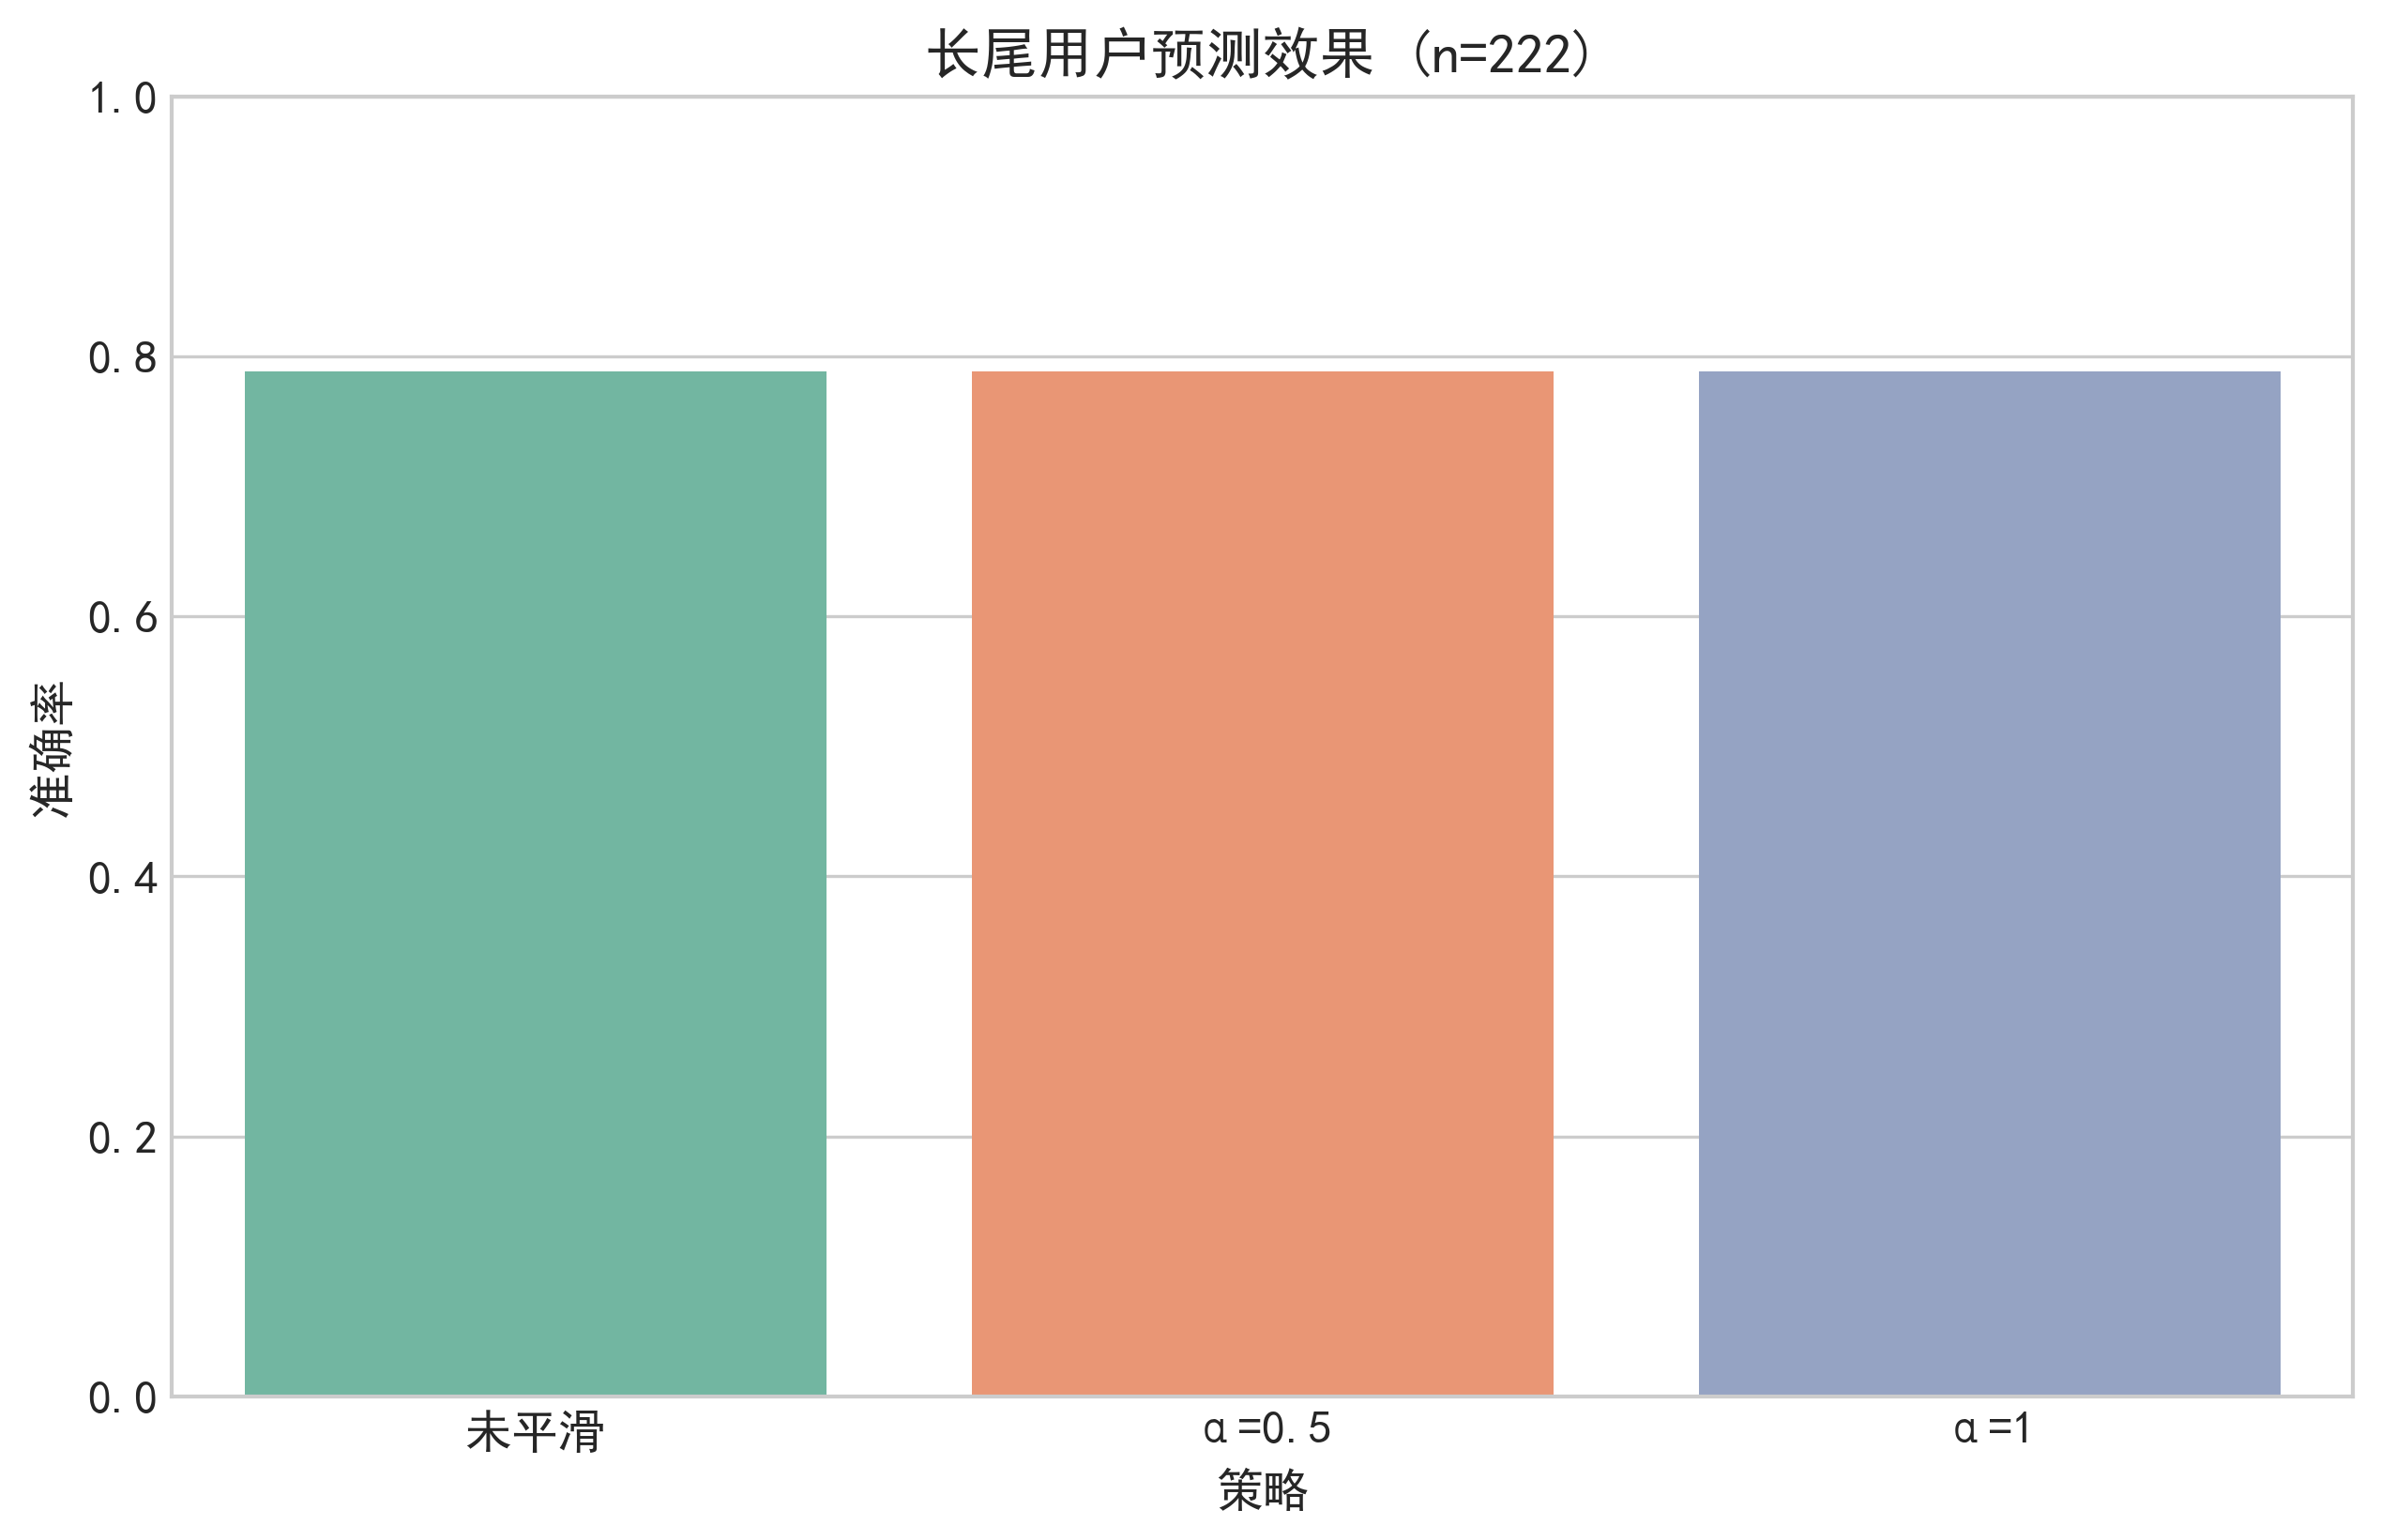

| 策略   |   准确率 |   加购转化率 |       F1 |
|:-------|---------:|-------------:|---------:|
| 未平滑 | 0.788288 |            1 | 0.117647 |
| α=0.5  | 0.788288 |            1 | 0.117647 |
| α=1    | 0.788288 |            1 | 0.117647 |


In [45]:
# 运行实验
results = run_longtail_experiment(df.head(800000))
print(results.to_markdown(index=False))

In [49]:
def deep_debug(df_sample):
    """深度调试函数"""
    # 特定状态分析
    target_state = "2355072_fav"
    
    # 统计该状态出现次数
    state_count = df_sample[df_sample['state'] == target_state].shape[0]
    print(f"\n状态 {target_state} 出现次数:", state_count)
    
    # 检查后续行为
    next_actions = df_sample[df_sample['state'].shift(1) == target_state]['behavior'].value_counts()
    print("后续行为分布:\n", next_actions)
    
    # 模型训练验证
    model = MarkovChain(alpha=0.5)
    model.train(df_sample)
    print(f"\n{target_state} 转移概率:", model.transition_matrix.get(target_state, "无记录"))

deep_debug(df.head(100000))  # 使用子集加速调试

KeyError: 'state'